In [1]:
import os, glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
])

color_rules = {
    "data_vertical": 0,
    "kitchen_horizon": 0, 
    "kitchen_random": 0, 
    "kitchen_three": 7, 
    "kitchen_vertical": 0, 
    "layout1_practical": 1,
    "layout2_parallel": 1,
    "layout2_practical": 1,
    "layout3_practical": 1,
    "layout4_practical": 1,
    "layout5_line1": 1,
    "layout6_triangle": 1,
    "layout7_triangle2": 1,
    "layout8_line2": 1, 
    "layout9_vertical1": 1,
    "layout10_vertical1": 2,
    "layout11_vertical1": 3,
    "layout12_vertical1": 5,
    "layout13_vertical2": 1,
    "layout14_vertical2": 2,
    "layout15_horizon2": 1,
    "layout16_horizon2": 2,
    "layout17_horizon1": 2, 
    "layout18_horizon1": 1,
    "layout19_horizon1": 4,
    "layout20_horizon1": 5,
    "layout21_vertical": 6,
    "layout22_horizon": 6,
    "layout23_circle": 6
}

palette = [0,0,0,  128,0,0,  0,128,0,  128,128,0,  0,0,128,  128,0,128,  0,128,128,  128,128,128,
					 64,0,0,  192,0,0,  64,128,0,  192,128,0,  64,0,128,  192,0,128,  64,128,128,  192,128,128,
					 0,64,0,  128,64,0,  0,192,0,  128,192,0,  0,64,128,  128,64,128,  0,192,128,  128,192,128,
					 64,64,0,  192,64,0,  64,192,0, 192,192,0]
# forks, knives, spoons, plates, bowls, mugs, cups, cans, tables
all_colors = []
# data_vertical
all_colors.append(torch.tensor([[  172, 6,  64,  -1,  39, -1, -1, -1, -1,  28],
        [245, 187, 236, -1, 131, -1, -1, -1, -1, 209],
        [153, 233, 211, -1, 245, -1, -1, -1, -1, 226]]))
# layout1~9, 13, 15, 18*
all_colors.append(torch.tensor([[ 243, 54, 232, -1, 188, -1, -1, -1, -1, 35],
        [ 246, 200,  28,   -1, 154, -1, -1, -1, -1, 16],
        [ 208, 25, 225, -1, 128, -1, -1, -1, -1, 64]]))
# layout10, 14, 16~17*
all_colors.append(torch.tensor([[ 243, 54, 232, 235, 188, -1, -1, -1, -1, 35],
        [ 246, 200,  28,   57, 154, -1, -1, -1, -1, 16],
        [ 208, 25, 225, 90, 128, -1, -1, -1, -1, 64]]))
# layout11*
all_colors.append(torch.tensor([[ 243, 54, 232, 20, 188, 235, -1, -1, -1, 35],
        [ 246, 200,  28, 182, 154,   57, -1, -1, -1, 16],
        [ 208, 25, 225, 193, 128, 90, -1, -1, -1, 64]]))
# layout19*
all_colors.append(torch.tensor([[ 243, 54, 232, -1, 188, 235, -1, -1, -1, 35],
        [ 246, 200,  28, -1, 154,   57, -1, -1, -1, 16],
        [ 208, 25, 225, -1, 128, 90, -1, -1, -1, 64]]))
# layout12, 20*
all_colors.append(torch.tensor([[ 243, -1, -1, -1, 188, 54, 232, -1, -1, 35],
        [ 246, -1, -1,   -1, 154, 200,  28, -1, -1, 16],
        [ 208, -1, -1, -1, 128, 25, 225, -1, -1, 64]]))
# layout21~23*
all_colors.append(torch.tensor([[ 243, -1, -1, -1, -1, 188, 54, 232, 235, 35],
        [ 246, -1, -1,   -1, -1, 154, 200,  28, 57, 16],
        [ 208, -1, -1, -1, -1, 128, 25, 225, 90, 64]]))
# kitchen_three
all_colors.append(torch.tensor([[  172, 6,  64,  47,  39, -1, -1, -1, -1,  28],
        [245, 187, 236, 120, 131, -1, -1, -1, -1, 209],
        [153, 233, 211, 247, 245, -1, -1, -1, -1, 226]]))

for file in glob.glob("datasets/YCB_kitchen_data/layout*/**/*_seg.png", recursive=True):
    image = Image.open(file)
    image = (transform(image) * 255).int()
    colors = all_colors[color_rules[file.split("/")[2]]]
    # print(torch.unique(image.reshape(image.shape[0], -1), dim=1))
    mask = torch.zeros_like(image[[0]])
    for i in range(colors.shape[1]):
        if i < 9:
             index = i
        else:
             index = 14
        mask[torch.all(((image - colors[:, [i]].unsqueeze(2)) == 0), dim=0).unsqueeze(0)] = index
    mask = transforms.ToPILImage()(mask.type(torch.uint8)).convert("P")
    mask.putpalette(palette)
    out_dirname = "./data"
    begin = False
    for dirs in os.path.dirname(file).split("/"):
        if begin:
            out_dirname = os.path.join(out_dirname, dirs)
        if dirs == "datasets":
            begin = True
    os.makedirs(out_dirname, exist_ok=True)
    mask.save(os.path.join(out_dirname, os.path.basename(file)))
#     break

In [17]:
import glob
import random

folder = "data/kitchen/data_four"
files = []
for file in glob.glob(f"{folder}/**/*_seg.png", recursive=True):
    files.append(file)
choice = random.choices(list(range(len(files))), k=int(len(files) * 0.7))

train_split = []
test_split = []
for index, file in enumerate(files):
    path = file.split("/")
    path = path[-2] + "/" + path[-1] + "\n"
    if index in choice:
        train_split.append(path)
    else:
        test_split.append(path)
train_split[-1] = train_split[-1].rstrip("\n")
test_split[-1] = test_split[-1].rstrip("\n")
with open(f"{folder}/instance_train_split.txt", "w") as f:
        f.writelines(train_split)
with open(f"{folder}/instance_test_split.txt", "w") as f:
        f.writelines(test_split)

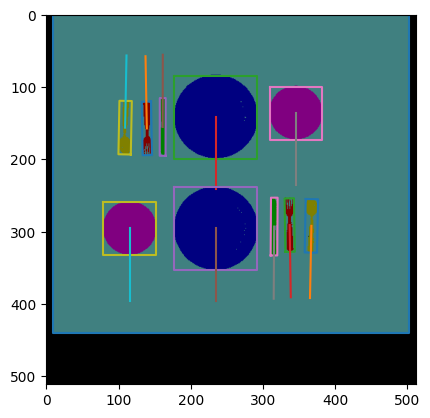

In [3]:
import os, glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2

orientation_rules = {
    "data_vertical": {"vertical": "all_down", "horizon": "no_preference"}, 
    "kitchen_horizon": {"vertical": "no_preference", "horizon": "all_right"},
    "kitchen_random": {"vertical": "all_down", "horizon": "all_right"},
    "kitchen_three": {"vertical": "all_down", "horizon": "all_right"},
    "kitchen_vertical": {"vertical": "all_down", "horizon": "no_preference"},
    "layout1_practical": {"vertical": "to_center", "horizon": "no_preference"},
    "layout2_parallel": {"vertical": "to_center", "horizon": "no_preference"},
    "layout2_practical": {"vertical": "to_center", "horizon": "no_preference"},
    "layout3_practical": {"vertical": "to_center", "horizon": "to_center"},
    "layout4_practical": {"vertical": "to_center", "horizon": "to_center"},
    "layout5_line1": {"vertical": "all_down", "horizon": "to_center"},
    "layout6_triangle": {"vertical": "all_down", "horizon": "to_center"},
    "layout7_triangle2": {"vertical": "all_down", "horizon": "to_center"},
    "layout8_line2": {"vertical": "no_preference", "horizon": "all_right"}, 
    "layout9_vertical1": {"vertical": "to_center", "horizon": "no_preference"},
    "layout10_vertical1": {"vertical": "to_center", "horizon": "no_preference"},
    "layout11_vertical1": {"vertical": "to_center", "horizon": "no_preference"},
    "layout12_vertical1": {"vertical": "force_down", "horizon": "no_preference"},
    "layout13_vertical2": {"vertical": "to_center", "horizon": "no_preference"},
    "layout14_vertical2": {"vertical": "to_center", "horizon": "all_right"},
    "layout15_horizon2": {"vertical": "no_preference", "horizon": "to_center"},
    "layout16_horizon2": {"vertical": "anticlockwise", "horizon": "to_center"},
    "layout17_horizon1": {"vertical": "no_preference", "horizon": "to_center"}, 
    "layout18_horizon1": {"vertical": "no_preference", "horizon": "to_center"},
    "layout19_horizon1": {"vertical": "no_preference", "horizon": "to_center"},
    "layout20_horizon1": {"vertical": "force_anticlockwise", "horizon": "no_preference"},
    "layout21_vertical": {"vertical": "force_down", "horizon": "no_preference"},
    "layout22_horizon": {"vertical": "force_down", "horizon": "no_preference"},
    "layout23_circle": {"vertical": "force_down", "horizon": "no_preference"}
}

transform = transforms.Compose([
    transforms.ToTensor()
])

pca = PCA(n_components=2)

for file in glob.glob("data/YCB_kitchen_data/**/*_seg.png", recursive=True):
    image = Image.open(file).convert("P")
    o_rule = orientation_rules[file.split("/")[2]]
    v_rule = o_rule["vertical"]
    h_rule = o_rule["horizon"]
    w, h = image.size
    plt.imshow(image)
    image = (transform(image) * 255).int()
    scene = {}
    for category in range(1, 15):
        if category == 14:
            index = torch.where(image == category)
            if len(index[0]) > 10:
                index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                up = min(index, key=lambda x: x[0])[0]
                bottom = max(index, key=lambda x: x[0])[0]
                left = min(index, key=lambda x: x[1])[1]
                right = max(index, key=lambda x: x[1])[1]
                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                bbox_w, bbox_h = right - left, bottom - up
                scene[category] = [{"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "type": torch.LongTensor([1])}]
                bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                bbox_mean = torch.mean(bbox.float(), dim=0)
                bbox = torch.cat([bbox, bbox[[0]]])
                plt.plot(bbox[:, 1], bbox[:, 0])
        else:
            index = (image == category).type(torch.uint8)
            objects, labels, stats, _ = cv2.connectedComponentsWithStats(index[0].numpy(), connectivity=8)
            if objects > 1:
                scene[category] = []
            for i in range(1, objects):
                index = torch.where(torch.from_numpy(labels).unsqueeze(0) == i)
                if len(index[0]) > 10:
                    index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                    index_mean = np.mean(index, axis=0)
                    index = index - index_mean
                    pca.fit(index)
                    if pca.explained_variance_ratio_[0] > pca.explained_variance_ratio_[1] + 0.1:
                        new_index = pca.transform(index)
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        bbox = torch.from_numpy(pca.inverse_transform(bbox) + index_mean)
                        orientation = torch.from_numpy(pca.components_[0])
                    else:
                        new_index = index + index_mean
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        orientation = torch.tensor([1, 0])
                    orientation = torch.nn.functional.normalize(orientation.float(), dim=0)
                    if category in [1, 2, 3, 6, 7, 8]:
                        theta = torch.atan2(orientation[1], orientation[0])
                        bbox_mean = torch.mean(bbox.float(), dim=0)
                        if v_rule == "to_center":
                            if (theta > 2.5 or theta < -2.5) and bbox_mean[0] > 0:
                                orientation = -orientation
                            if -0.5 < theta < 0.5 and bbox_mean[0] < 0:
                                orientation = -orientation
                        elif v_rule == "anticlockwise":
                            if (theta > 2.5 or theta < -2.5) and bbox_mean[1] > 0:
                                orientation = -orientation
                            if -0.5 < theta < 0.5 and bbox_mean[1] < 0:
                                orientation = -orientation
                        elif v_rule == "all_up":
                            if -0.5 < theta < 0.5:
                                orientation = -orientation
                        elif v_rule == "all_down":
                            if theta > 2.5 or theta < -2.5:
                                orientation = -orientation
                        elif v_rule == "force_anticlockwise":
                            new_index = index + index_mean
                            up = min(new_index, key=lambda x: x[0])[0]
                            bottom = max(new_index, key=lambda x: x[0])[0]
                            left = min(new_index, key=lambda x: x[1])[1]
                            right = max(new_index, key=lambda x: x[1])[1]
                            bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                            bbox_w, bbox_h = right - left, bottom - up
                            orientation = torch.tensor([1, 0])
                            if bbox_mean[1] > 0:
                                orientation = -orientation
                        elif v_rule == "force_down":
                            new_index = index + index_mean
                            up = min(new_index, key=lambda x: x[0])[0]
                            bottom = max(new_index, key=lambda x: x[0])[0]
                            left = min(new_index, key=lambda x: x[1])[1]
                            right = max(new_index, key=lambda x: x[1])[1]
                            bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                            bbox_w, bbox_h = right - left, bottom - up
                            orientation = torch.tensor([1, 0])
                        if h_rule == "to_center":
                            if 2 > theta > 1 and bbox_mean[1] < 0:
                                orientation = -orientation
                            if -2 < theta < -1 and bbox_mean[1] > 0:
                                orientation = -orientation
                        elif h_rule == "all_left":
                            if 2 > theta > 1:
                                orientation = -orientation
                        elif h_rule == "all_right":
                            if -2 < theta < -1:
                                orientation = -orientation
                    scene[category].append({"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "orientation": orientation})
                    bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                    bbox_mean = torch.mean(bbox.float(), dim=0)
                    orientation = bbox_mean + orientation * 100
                    bbox = torch.cat([bbox, bbox[[0]]])
                    plt.plot(bbox[:, 1], bbox[:, 0])
                    plt.plot([bbox_mean[1], orientation[1]], [bbox_mean[0], orientation[0]])
    # torch.save(scene, os.path.join(os.path.dirname(file), os.path.basename(file).split(".")[0] + ".pt"))
    # mask = torch.zeros_like(image)
    # mask[image == category] = 1
    # mask = transforms.ToPILImage()(mask.type(torch.uint8))
    # plt.imshow(mask, cmap="gray")
    break

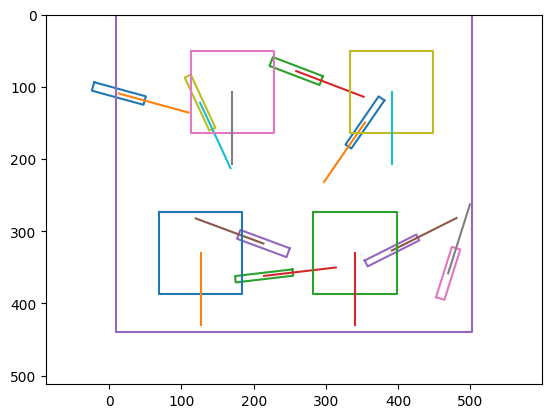

In [4]:
import os, glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

for file in glob.glob("data/YCB_kitchen_data/layout1_practical/**/*.pt", recursive=True):
    scene = torch.load(file)
    plt.axis("equal")
    plt.xlim(0, 512)
    plt.ylim(512, 0)
    for c in scene:
        for instance in scene[c]:
            h, w = instance["img_size"].float()
            bbox = instance["bbox"].float()
            bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
            orientation = instance["orientation"].float()
            bbox_mean = torch.mean(bbox, dim=0)
            trans = torch.tensor([0, 0])
            rotate = torch.tensor(0)
            if c == 4 or c == 9:
                trans = torch.tensor([0, 0])
                rotate = torch.tensor(0)
            else:
                trans = torch.randn(2) * 30
                rotate = (torch.rand(1) - 0.5) * torch.pi
            matrix = torch.tensor([[torch.cos(rotate), torch.sin(-rotate)], [torch.sin(rotate), torch.cos(rotate)]])
            bbox = torch.mm(bbox - bbox_mean, matrix) + bbox_mean + trans
            bbox_mean = torch.mean(bbox, dim=0)
            bbox = torch.cat([bbox, bbox[[0]]])
            orientation = bbox_mean + torch.mm(orientation.unsqueeze(0), matrix)[0] * 100
            plt.plot(bbox[:, 1], bbox[:, 0])
            if c != 9:
                plt.plot([bbox_mean[1], orientation[1]], [bbox_mean[0], orientation[0]])
    break

['((0.20440827295166059, -0.08141543625338657, 0.830786714256275), [1, 0, 0, 0], <robosuite.models.objects.primitive.box.BoxObject object at 0x7fad18102a40>)'
 '((0.2028763408720013, 0.011960214258980598, 0.8319905877005396), [1, 0, 0, 0], <robosuite.models.objects.primitive.box.BoxObject object at 0x7fad181021d0>)'
 '((-0.1443639015894318, -0.04833604629318565, 0.8200000000000001), [1, 0, 0, 0], <robosuite.models.objects.xml_objects.PlateObject object at 0x7fad18102ec0>)'
 '((-0.1443639015894318, 0.15166395370681435, 0.8200000000000001), [1, 0, 0, 0], <robosuite.models.objects.xml_objects.ForkObject object at 0x7fad9baf7d60>)'
 '((-0.1443639015894318, -0.19833604629318563, 0.8200000000000001), [1, 0, 0, 0], <robosuite.models.objects.xml_objects.KnifeObject object at 0x7fad9baf7550>)']


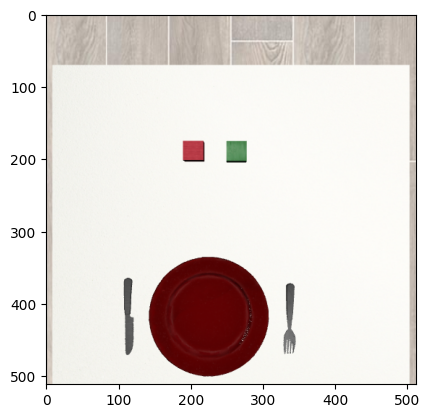

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

x = pd.read_csv("datasets/kitchen/data_vertical/data1/data.csv")
print(x.values[1])
image = Image.open("datasets/kitchen/data_vertical/data1/1.png")
plt.imshow(image)

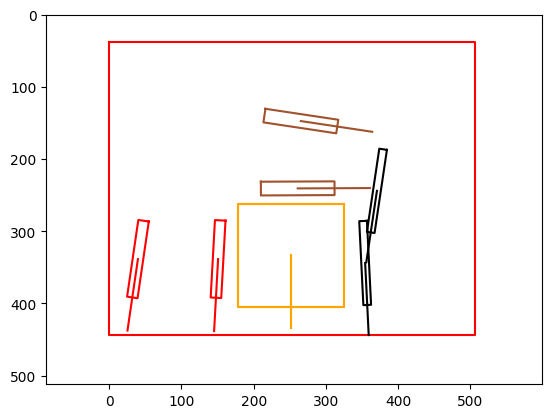

In [1]:
from scripts.dataset import TableDataset
import torch
import numpy as np
from scripts.utils import visual_noise, visual_noise_denoise
from scripts.noise_schedule import NoiseSchedule
from omegaconf import OmegaConf

data_config = OmegaConf.load("configs/Kinect_image.yaml")
# data_config = OmegaConf.load("configs/YCB_Inpainted.yaml")

dataset = TableDataset(path=[data_config["dataset_path"]], num_class=data_config["num_class"])
schedule = NoiseSchedule(1000)
t = torch.randint(0, schedule.timesteps, (1,), dtype=torch.long)
input, mask, cond, word, labels, padding_mask, _, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, data_augment=1, random_idx=np.array([0]), data_partition="test", use_move_less=True, no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=False, noise_level_stddev=0.5, angle_noise_level_stddev=np.pi/3)
input = torch.tensor(input)
mask = torch.tensor(mask)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)

idx = 0
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in mask[idx]]
visual_noise_denoise(clean_scenepaths[idx], input[idx], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# visual_noise(clean_scenepaths[idx], input[idx], padding_mask[idx], target_bbox=target_bbox)

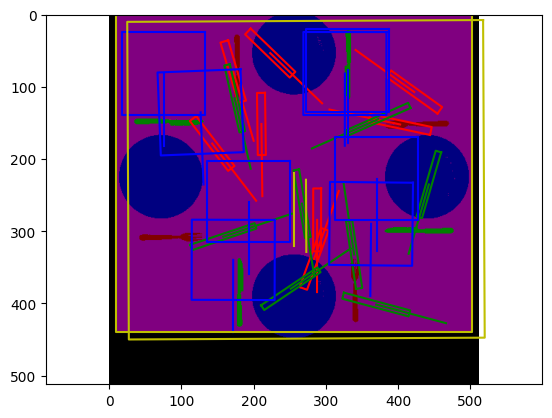

In [1]:
import os, glob
import torch
import numpy as np
from scripts.model import Denoiser
from scripts.dataset import TableDataset
from scripts.utils import visual_noise_denoise

dataset = TableDataset(path="data/kitchen")
input, cond, _, padding_mask, clean_scenepaths = dataset.gen_kitchen(1, random_idx=np.array([0]), data_partition="test", within_floorplan=True, no_penetration=True, noise_level_stddev=1, angle_noise_level_stddev=np.pi/2)
bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
input = torch.tensor(input)
padding_mask = torch.tensor(padding_mask)

denoiser = Denoiser(cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)
for old_best_checkpoint in glob.glob(os.path.join("./log_livingroom/1212_164451_578__FTF_", "best*")):
    checkpoint = torch.load(old_best_checkpoint, map_location="cuda:1")
    break
denoiser.load_state_dict(checkpoint['model_state_dict'])

cond = denoiser.encode_cond(cond, input.device)
un_cond = denoiser.encode_cond(input.shape[0] * [""], input.device)
with torch.no_grad():
# input           : [batch_size, maxnumobj, pos+ang+siz+cla]
    output = denoiser(input, padding_mask, condition=cond, un_condition=un_cond)
# input           : [batch_size, maxnumobj, pos+ang]
pred_means, pred_orientations = output[:, :, :2].numpy(), output[:, :, 2:4]
pred_orientations = torch.nn.functional.normalize(pred_orientations.float(), dim=-1).numpy()

idx = 0
visual_noise_denoise(clean_scenepaths[idx], input[idx], output[idx], padding_mask[idx])

In [10]:
import glob, os, copy
import torch
import numpy as np
from scripts.model import Denoiser
from scripts.dataset import TableDataset
from scripts.noise_schedule import NoiseSchedule
from train import denoise_1scene, adjust_parameters
from omegaconf import OmegaConf

# data_config = OmegaConf.load("configs/YCB_kitchen.yaml")
data_config = OmegaConf.load("configs/YCB_Inpainted.yaml")

dataset = TableDataset(path=[data_config["dataset_path"]], num_class=data_config["num_class"])
schedule = NoiseSchedule(1000)
predict_absolute_pos = 1
predict_absolute_ang = 1
noise_level_stddev=1.0
angle_noise_level_stddev=np.pi / 3
t = torch.randint(0, schedule.timesteps, (1,), dtype=torch.long)
input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, random_idx=np.array([0]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition="test", no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=False, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
input = torch.tensor(input)
mask = torch.tensor(mask)
word = torch.tensor(word)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)
mask_padding_mask = torch.tensor(mask_padding_mask)

use_position = False
use_time = False
use_text = True
time_form="add"
text_form="word"
denoiser = Denoiser(cla_dim=dataset.cla_dim, max_position=dataset.maxnobj, time_form=time_form, text_form=text_form, mask_types=data_config["mask_types"], use_position = use_position, use_time = use_time, use_text = use_text, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)
if use_text:
    if text_form == "word":
        cond = None
        un_cond = None
    elif text_form == "sentence":
        # cond = ['Knives and forks are placed on the same side of the plates, while four plates are placed horizontally in a row.']
        cond = denoiser.encode_cond(cond, input.device)
        un_cond = denoiser.encode_cond(input.shape[0] * [""], input.device)
        word = None
else:
    cond = None
    un_cond = None
    word = None

In [13]:
for old_best_checkpoint in glob.glob(os.path.join("./logs/YCB_Inpainted/0129_112514_562__FTFFFT_", "best*")):
    # checkpoint = torch.load(old_best_checkpoint, map_location="cuda:0")
    checkpoint = torch.load(old_best_checkpoint, map_location="cpu")
    break
denoiser.load_state_dict(checkpoint['model_state_dict'])

args = {}
args["device"] = input.device
args['predict_absolute_pos'] = predict_absolute_pos
args['predict_absolute_ang'] = predict_absolute_ang
args['train_pos_noise_level_stddev'] = noise_level_stddev
args['train_ang_noise_level_stddev'] = angle_noise_level_stddev

# word = torch.LongTensor([[1, 2]])
# cond_scale_guidance = 2.0
cond_scale_guidance = 1.0
adjust_parameters(train = False)
denoiser.eval()
new_mask = mask
# new_mask = torch.tensor([
#     [bbox_y-0.1, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[0]
#     ]).unsqueeze(0)
# new_mask = torch.tensor([
#     [bbox_y-0.2, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[0]
#     ]).unsqueeze(0)
# target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
# t = torch.LongTensor([200])

pred = denoiser(input, padding_mask, mask, mask_padding_mask, t, word=word, condition=cond, un_condition=un_cond, cond_scale_guidance=cond_scale_guidance)
for scene in range(input.shape[0]):
    nobject = padding_mask[scene] == 0
    if scene == 0:
        loss = torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
    else:
        loss += torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
print(loss / input.shape[0])
loss = torch.nn.MSELoss(reduction="none")(pred, labels) + 0.07 * torch.nn.L1Loss(reduction="none")(pred, labels)
# print(torch.mean(loss, dim=[1, 2]))
print(torch.mean(loss, dim=2))

# target_bbox=(-0.3, -0.3, 0.6, 1.2)
# guidance_scale = 3.0
with torch.no_grad():
    traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, cond, un_cond, word, args, "grad_noise", input.device, denoiser, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
print(perobj_distmoved)

tensor(0.0054, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([[0.0067, 0.0042, 0.0061, 0.0043, 0.0051, 0.0092, 0.0033, 0.0047, 0.0062,
         0.0039, 0.0042, 0.0071]], dtype=torch.float64,
       grad_fn=<MeanBackward1>)
0.20057328499379826 0.10953065115623996 0.00017155119172232447 0.3333333333333333 0.25


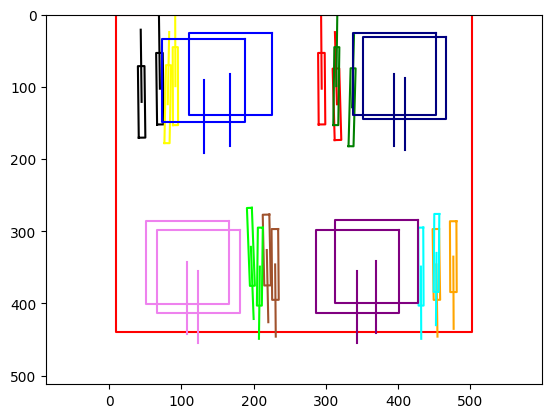

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scripts.utils import visual_noise, visual_noise_denoise

idx = 0
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

fig = plt.figure()

def update(tr):
    plt.cla()
    visual_noise(clean_scenepaths[idx], traj_to_return[tr], padding_mask[idx], target_bbox=target_bbox)
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[tr], labels[idx], padding_mask[idx], target_bbox=target_bbox)

ani = animation.FuncAnimation(fig, update, frames=traj_to_return.shape[0] // 10, interval=1)
ani.save('sine_wave.gif')
plt.show()

In [1]:
import glob, os, json, copy
import torch
import numpy as np
from scripts.model import Denoiser
from scripts.dataset import TableDataset
from train import denoise_1scene

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scripts.utils import visual_noise

dataset = TableDataset(path="data/YCB_kitchen_data")
input, cond, labels, padding_mask, clean_scenepaths = dataset.gen_kitchen(1, random_idx=np.array([0]), data_partition="test", no_rotate_class=[4, 5, 7], static_class=[], same_class=[], floorplan_class=1, within_floorplan=True, no_penetration=False, noise_level_stddev=2, angle_noise_level_stddev=np.pi)
bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
input = torch.tensor(input)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)

with open("data/YCB_kitchen_data/split.json") as f:
            split_j = json.load(f)

denoiser = Denoiser(cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)
for old_best_checkpoint in glob.glob(os.path.join("./log_livingroom/1215_155356_835__FTF_", "best*")):
    checkpoint = torch.load(old_best_checkpoint, map_location="cuda:1")
    break
denoiser.load_state_dict(checkpoint['model_state_dict'])

args = {}
args["device"] = input.device
args['predict_absolute_pos'] = 1
args['predict_absolute_ang'] = 1

un_cond = denoiser.encode_cond(input.shape[0] * [""], input.device)
cond_desc = [split_j[1][l]["description"] for l in split_j[1]] + [""]
save_desc = list(split_j[1].keys()) + ["uncond"]
for c, save in zip(cond_desc, save_desc):
    c = denoiser.encode_cond(input.shape[0] * [c], input.device)

    with torch.no_grad():
        traj_to_return, _, _, _, _ = denoise_1scene(copy.deepcopy(input), c, un_cond, args, "grad_noise", input.device, denoiser, no_rotate_class=[4, 5, 7], static_class=[9], padding_mask=padding_mask, steer_away=False)

    idx = 0

    fig = plt.figure()

    def update(tr):
        plt.cla()
        visual_noise(clean_scenepaths[idx], traj_to_return[tr], padding_mask[idx])

    ani = animation.FuncAnimation(fig, update, frames=traj_to_return.shape[0] // 10, interval=1)
    ani.save(f'{save}.gif')
    # plt.show()
    plt.close(fig)

In [1]:
import os, glob, json
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor()
])

color_rules = {
    "layout1": {
        "shape1": 0,
        "shape2": 0,
        "shape3": 0, 
        "shape4": 1, 
        "shape5": 0
    }, 
    "layout2": {
        "shape1": 0,
        "shape2": 0,
        "shape3": 0
    }, 
    "layout3": {
        "shape1": 0,
        "shape2": 0,
        "shape3": 1,
        "shape4": 2, 
        "shape5": 3, 
        "shape6": 4, 
        "shape7": 5, 
        "shape8": 6, 
        "shape9": 2, 
        "shape10": 7, 
        "shape11": 8, 
        "shape12": 9, 
        "shape13": 10
    }, 
    "layout4": {
        "shape1": 0,
        "shape2": 1,
        "shape3": 2,
        "shape4": 0, 
        "shape5": 1, 
        "shape6": 2
    }
}

palette = [0,0,0,  128,0,0,  0,128,0,  128,128,0,  0,0,128,  128,0,128,  0,128,128,  128,128,128,
					 64,0,0,  192,0,0,  64,128,0,  192,128,0,  64,0,128,  192,0,128,  64,128,128,  192,128,128,
					 0,64,0,  128,64,0,  0,192,0,  128,192,0,  0,64,128,  128,64,128,  0,192,128,  128,192,128,
					 64,64,0,  192,64,0,  64,192,0, 192,192,0]
# forks, knives, spoons, plates, bowls, mugs, cups, cans, boxes, bottles, bananas, berries, mask, table
all_colors = {}
layout_colors = []
# shape1~3, 5
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, -1, -1, -1, -1,  0,  64]]))
# shape4
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, 232,  54, -1, -1,  -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154,  28, 200, -1,  -1, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, 225,  25, -1,  -1, -1, -1, 0,  64]]))
all_colors["layout1"] = layout_colors
layout_colors = []
# shape1~3
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, -1, -1, -1, -1,  0,  64]]))
all_colors["layout2"] = layout_colors
layout_colors = []
# shape1~2
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200, -1, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, -1, -1, -1, 0,  64]]))
# shape3
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, 232, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200, 28, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, 225, -1, -1,  0,  64]]))
# shape4, 9
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, 232, 235,  20, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200,  28,  57, 182, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, 225,  90, 193, 0,  64]]))
# shape5
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200, -1, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, -1, -1, -1, 0,  64]]))
# shape6
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, 232, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200, 28, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, 225, -1, -1,  0,  64]]))
# shape7
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, 232, -1,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200,  28,  -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, 225,  -1, -1, 0,  64]]))
# shape8
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, 232, 235,  20, 8, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1,  28,  57, 182, 94, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, 225,  90, 193, 186, 0,  64]]))
# shape10
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188, -1, -1,  54, 232, -1,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, 200,  28,  -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128, -1, -1,  25, 225,  -1, -1, 0,  64]]))
# shape11
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1, 232,  54, 235,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1,  28, 200,  57, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1, 225,  25,  90, -1, 0,  64]]))
# shape12
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, -1, 188, -1,  54, 232, 235,  -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, -1, 154, -1, 200,  28,  57, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, -1, 128, -1,  25, 225,  90, -1, 0,  64]]))
# shape13
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, 232, 235,  -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1,  28,  57, -1, -1, 0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, 225,  90, -1, -1, 0,  64]]))
all_colors["layout3"] = layout_colors
layout_colors = []
# shape1
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  -1, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, -1, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  -1, -1, -1, -1, -1, -1,  0,  64]]))
# shape2
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, -1, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, -1, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, -1, -1, -1, -1, -1,  0,  64]]))
# shape3
layout_colors.append(torch.tensor([[  243, -1, -1, -1, -1, -1, -1, -1, 188,  54, 232, -1, -1, -1, -1, 0,  35],
        [  246, -1, -1, -1, -1, -1, -1, -1, 154, 200, 28, -1, -1, -1, -1,  0,  16],
        [  208, -1, -1, -1, -1, -1, -1, -1, 128,  25, 225, -1, -1, -1, -1,  0,  64]]))
all_colors["layout4"] = layout_colors

category_index = {
    "fork": 1, "knife": 2, "spoon": 3, "plate": 4, "bowl": 5, "mug": 6, "cup": 7, "can": 8, "box": 9, "bottle": 10, "banana": 11, "berry": 12
    }
category = {}
with open("datasets/YCB_Inpainted_data/layout4/category.json") as f:
    category_match = json.load(f)
category["layout4"] = category_match

for file in glob.glob("datasets/YCB_Inpainted_data/**/*_seg.png", recursive=True):
    image = Image.open(file)
    image = (transform(image) * 255).int()
    layout = file.split("/")[2]
    shape = file.split("/")[3]
    colors = all_colors[layout][color_rules[layout][shape]]
#     print(torch.unique(image.reshape(image.shape[0], -1), dim=1))
    mask = torch.zeros_like(image[[0]])
    for i in range(colors.shape[1]):
        if (layout == "layout1" and shape == "shape5") or (layout == "layout2" and shape == "shape3"):
            if i == 0:
                index = i
            elif 8 <= i <= 9:
                index = 18 - i
            else:
                index = i - 2
        elif (layout == "layout3" and shape == "shape7") or (layout == "layout3" and shape == "shape10") or (layout == "layout3" and shape == "shape13"):
            if 0 <= i <= 10:
                index = i
            elif 11 <= i <= 14:
                index = 12
            else:
                index = i - 2
        elif layout == "layout4":
            if 0 <= i <= 7:
                index = i
            elif 8 <= i <= 10:
                category_match = category[layout][shape][file.split("/")[4].split(".")[0]]
                if i - 8 < len(category_match):
                    index = category_index[category_match[i - 8]]
                else:
                    index = 0
            else:
                index = i - 2
        else:
            if 0 <= i <= 11:
                index = i
            elif 12 <= i <= 14:
                index = 12
            else:
                index = i - 2
        mask[torch.all(((image - colors[:, [i]].unsqueeze(2)) == 0), dim=0).unsqueeze(0)] = index
    mask = transforms.ToPILImage()(mask.type(torch.uint8)).convert("P")
    mask.putpalette(palette)
    out_dirname = "./data"
    begin = False
    for dirs in os.path.dirname(file).split("/"):
        if begin:
            out_dirname = os.path.join(out_dirname, dirs)
        if dirs == "datasets":
            begin = True
    os.makedirs(out_dirname, exist_ok=True)
    mask.save(os.path.join(out_dirname, os.path.basename(file)))
    # break

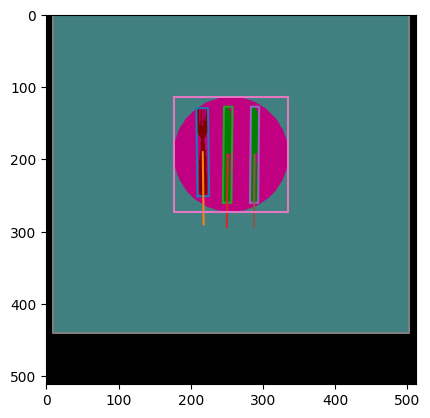

In [5]:
import os, glob
from PIL import Image
import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2

orientation_rules = {
    "layout1" : {
        "shape1": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "force_right"},
        "shape3": {"vertical": "force_down", "horizon": "force_right"},
        "shape4": {"vertical": "force_down", "horizon": "force_right"},
        "shape5": {"vertical": "all_down", "horizon": "force_right"}
    }, 
    "layout2" : {
        "shape1": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "force_right"},
        "shape3": {"vertical": "all_down", "horizon": "force_right"}
    }, 
    "layout3" : {
        "shape1": {"vertical": "force_down", "horizon": "all_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "all_right"},
        "shape3": {"vertical": "force_down", "horizon": "all_right"},
        "shape4": {"vertical": "force_down", "horizon": "all_right"},
        "shape5": {"vertical": "no_preference", "horizon": "force_right"},
        "shape6": {"vertical": "force_down", "horizon": "force_right"},
        "shape7": {"vertical": "force_down", "horizon": "force_right"},
        "shape8": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape9": {"vertical": "force_down", "horizon": "all_right"}, 
        "shape10": {"vertical": "force_down", "horizon": "no_preference"}, 
        "shape11": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape12": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape13": {"vertical": "force_down", "horizon": "force_right"}
    }, 
    "layout4" : {
        "shape1": {"vertical": "force_down", "horizon": "force_right"}, 
        "shape2": {"vertical": "force_down", "horizon": "force_right"},
        "shape3": {"vertical": "force_down", "horizon": "force_right"},
        "shape4": {"vertical": "force_down", "horizon": "no_preference"},
        "shape5": {"vertical": "force_down", "horizon": "all_right"},
        "shape6": {"vertical": "force_down", "horizon": "force_right"}
    }
}

transform = transforms.Compose([
    transforms.ToTensor()
])

pca = PCA(n_components=2)

for file in glob.glob("data/YCB_Inpainted_data/**/*_seg.png", recursive=True):
    image = Image.open(file).convert("P")
    layout = file.split("/")[2]
    shape = file.split("/")[3]
    o_rule = orientation_rules[layout][shape]
    v_rule = o_rule["vertical"]
    h_rule = o_rule["horizon"]
    w, h = image.size
    plt.imshow(image)
    image = (transform(image) * 255).int()
    scene = {}
    for category in range(1, 15):
        if category == 14:
            index = torch.where(image == category)
            if len(index[0]) > 10:
                index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                up = min(index, key=lambda x: x[0])[0]
                bottom = max(index, key=lambda x: x[0])[0]
                left = min(index, key=lambda x: x[1])[1]
                right = max(index, key=lambda x: x[1])[1]
                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                bbox_w, bbox_h = right - left, bottom - up
                scene[category] = [{"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "type": torch.LongTensor([1])}]
                bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                bbox_mean = torch.mean(bbox.float(), dim=0)
                bbox = torch.cat([bbox, bbox[[0]]])
                plt.plot(bbox[:, 1], bbox[:, 0])
        elif category == 13:
            index = (image == category).type(torch.uint8)
            objects, labels, stats, _ = cv2.connectedComponentsWithStats(index[0].numpy(), connectivity=4)
            if objects > 1:
                scene[category] = []
            for i in range(1, objects):
                index = torch.where(torch.from_numpy(labels).unsqueeze(0) == i)
                if len(index[0]) > 10:
                    index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                    up = min(index, key=lambda x: x[0])[0]
                    bottom = max(index, key=lambda x: x[0])[0]
                    left = min(index, key=lambda x: x[1])[1]
                    right = max(index, key=lambda x: x[1])[1]
                    bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                    bbox_w, bbox_h = right - left, bottom - up
                    if np.abs(bbox_w - bbox_h) > 0.05:
                        mask_type = 2
                    else:
                        mask_type = 3
                    scene[category].append({"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "type": torch.LongTensor([mask_type])})
                    bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                    bbox_mean = torch.mean(bbox.float(), dim=0)
                    bbox = torch.cat([bbox, bbox[[0]]])
                    plt.plot(bbox[:, 1], bbox[:, 0])
        else:
            index = (image == category).type(torch.uint8)
            objects, labels, stats, _ = cv2.connectedComponentsWithStats(index[0].numpy(), connectivity=4)
            if objects > 1:
                scene[category] = []
            for i in range(1, objects):
                index = torch.where(torch.from_numpy(labels).unsqueeze(0) == i)
                if len(index[0]) > 10:
                    index = list(zip(2 * index[1].numpy() / (h - 1) - 1, 2 * index[2].numpy() / (w - 1) - 1))
                    index_mean = np.mean(index, axis=0)
                    index = index - index_mean
                    pca.fit(index)
                    if pca.explained_variance_ratio_[0] > pca.explained_variance_ratio_[1] + 0.1:
                        new_index = pca.transform(index)
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        bbox = torch.from_numpy(pca.inverse_transform(bbox) + index_mean)
                        orientation = torch.from_numpy(pca.components_[0])
                    else:
                        new_index = index + index_mean
                        up = min(new_index, key=lambda x: x[0])[0]
                        bottom = max(new_index, key=lambda x: x[0])[0]
                        left = min(new_index, key=lambda x: x[1])[1]
                        right = max(new_index, key=lambda x: x[1])[1]
                        bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                        bbox_w, bbox_h = right - left, bottom - up
                        orientation = torch.tensor([1, 0])
                    orientation = torch.nn.functional.normalize(orientation.float(), dim=0)
                    if category in [1, 2, 3, 8, 9, 10, 11, 12]:
                        theta = torch.atan2(orientation[1], orientation[0])
                        bbox_mean = torch.mean(bbox.float(), dim=0)
                        if v_rule == "all_up":
                            if -0.5 < theta < 0.5:
                                orientation = -orientation
                        elif v_rule == "all_down":
                            if theta > 2.5 or theta < -2.5:
                                orientation = -orientation
                        elif v_rule == "force_down":
                            if theta > 2.5 or theta < -2.5:
                                orientation = -orientation
                            if category in [8, 12]:
                                new_index = index + index_mean
                                up = min(new_index, key=lambda x: x[0])[0]
                                bottom = max(new_index, key=lambda x: x[0])[0]
                                left = min(new_index, key=lambda x: x[1])[1]
                                right = max(new_index, key=lambda x: x[1])[1]
                                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                                bbox_w, bbox_h = right - left, bottom - up
                                orientation = torch.tensor([1, 0])
                        theta = torch.atan2(orientation[1], orientation[0])
                        if h_rule == "all_right":
                            if -2 < theta < -1:
                                orientation = -orientation
                        elif h_rule == "force_right":
                            if -2 < theta < -1:
                                orientation = -orientation
                            if category in [9]:
                                # if theta > 2.5 or theta < -2.5:
                                #     orientation = torch.tensor([-orientation[1], orientation[0]])
                                # elif -0.5 < theta < 0.5:
                                #     orientation = torch.tensor([orientation[1], -orientation[0]])
                                new_index = index + index_mean
                                up = min(new_index, key=lambda x: x[0])[0]
                                bottom = max(new_index, key=lambda x: x[0])[0]
                                left = min(new_index, key=lambda x: x[1])[1]
                                right = max(new_index, key=lambda x: x[1])[1]
                                bbox = torch.tensor([[up, left], [up, right], [bottom, right], [bottom, left]])
                                bbox_w, bbox_h = right - left, bottom - up
                                bbox_h, bbox_w = bbox_w, bbox_h
                                orientation = torch.tensor([0, 1])
                    scene[category].append({"img_size": torch.tensor([h, w]), "bbox": bbox, "bbox_size": torch.tensor([bbox_h, bbox_w]) - 1, "orientation": orientation})
                    bbox = (bbox + 1) * (torch.tensor([[h, w]]) - 1) / 2
                    bbox_mean = torch.mean(bbox.float(), dim=0)
                    orientation = bbox_mean + orientation * 100
                    bbox = torch.cat([bbox, bbox[[0]]])
                    plt.plot(bbox[:, 1], bbox[:, 0])
                    plt.plot([bbox_mean[1], orientation[1]], [bbox_mean[0], orientation[0]])
    # torch.save(scene, os.path.join(os.path.dirname(file), os.path.basename(file).split(".")[0] + ".pt"))
    # mask = torch.zeros_like(image)
    # mask[image == category] = 1
    # mask = transforms.ToPILImage()(mask.type(torch.uint8))
    # plt.imshow(mask, cmap="gray")
    break

In [3]:
import glob, os, copy
import torch
import numpy as np
from scripts.model import Predictor
from scripts.dataset import TableDataset
from scripts.noise_schedule import NoiseSchedule
from scripts.utils import visual_noise
from train import denoise_1scene, adjust_parameters

dataset = TableDataset(path="data/YCB_Inpainted_data", num_class=5)
schedule = NoiseSchedule(1000)
predict_absolute_pos = 1
predict_absolute_ang = 1
noise_level_stddev=0.5
angle_noise_level_stddev=np.pi/3
adjust_parameters(train = False)

use_text = True
time_form="add"
text_form = "word"
denoiser = Predictor(cla_dim=dataset.cla_dim, mask_types=3, use_text = use_text, text_form = text_form, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32, final_lin_unit = [256, 1])
if use_text:
    if text_form == "word":
        cond = None
        un_cond = None
    elif text_form == "sentence":
        # cond = ['Knives and forks are placed on the same side of the plates, while four plates are placed horizontally in a row.']
        cond = denoiser.encode_cond(cond, input.device)
        un_cond = denoiser.encode_cond(input.shape[0] * [""], input.device)
        word = None
else:
    cond = None
    un_cond = None
    word = None

for old_best_checkpoint in glob.glob(os.path.join("logs/YCB_Inpainted/0114_220530_843__FTFT__predictor", "best*")):
    checkpoint = torch.load(old_best_checkpoint, map_location="cuda:1")
    break
denoiser.load_state_dict(checkpoint['model_state_dict'])
denoiser.eval()
print(schedule.timesteps)

1000


tensor([0.2500]) tensor([[0.4964]])


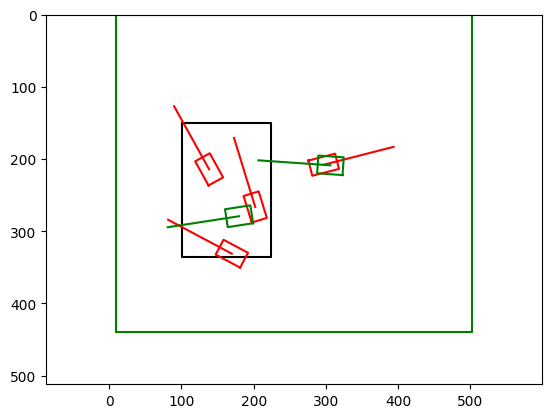

In [6]:
t = torch.randint(0, schedule.timesteps, (1,), dtype=torch.long)
input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, random_idx=np.array([0]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition="test", no_rotate_class=[4, 5, 7], static_class=[], same_class=[], floorplan_class=1, within_floorplan=True, no_penetration=False, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
input = torch.tensor(input)
mask = torch.tensor(mask)
word = torch.tensor(word)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)
mask_padding_mask = torch.tensor(mask_padding_mask)

idx = 0
new_mask = mask
# new_mask = torch.tensor([
#     [bbox_y-0.1, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[0]
#     ]).unsqueeze(0)
# new_mask = torch.tensor([
#     [bbox_y-0.2, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[0]
#     ]).unsqueeze(0)
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]
# target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
# t = torch.LongTensor([200])

# target_bbox=(-0.3, -0.3, 0.6, 1.2)
# guidance_scale = 3.0
with torch.no_grad():
    pred = denoiser(input, padding_mask, new_mask, mask_padding_mask, word=word, condition=cond, un_condition=un_cond)
print(t / schedule.timesteps, pred)

visual_noise(clean_scenepaths[idx], input[idx], padding_mask[idx], target_bbox=target_bbox)

In [1]:
import os, json
import glob

path = ["data/YCB_kitchen_data", "data/YCB_Inpainted_data"]
train_global, train_local, test_global, test_local = [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 0, 0, 0]
for p in path:
    with open(f"{p}/split.json") as f:
        split_j = json.load(f)
    for l in split_j[0]:
        for f in split_j[0][l]["folder"]:
            files = glob.glob(os.path.join(p, l, f, "*.pt"))
            train_global[split_j[0][l]["shape"]] += len(files)
            train_local[split_j[0][l]["surround"]] += len(files)
    for l in split_j[1]:
        for f in split_j[1][l]["folder"]:
            files = glob.glob(os.path.join(p, l, f, "*.pt"))
            test_global[split_j[1][l]["shape"]] += len(files)
            test_local[split_j[1][l]["surround"]] += len(files)
print(train_global, train_local, test_global, test_local)
print(sum(train_global), sum(test_global), sum(train_local) + sum(test_local))

[120, 300, 480, 420, 320] [500, 600, 420, 120, 0] [40, 100, 160, 140, 143] [203, 200, 140, 40, 0]
1640 583 2223


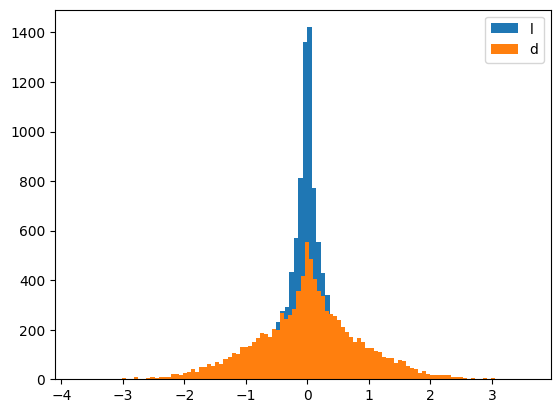

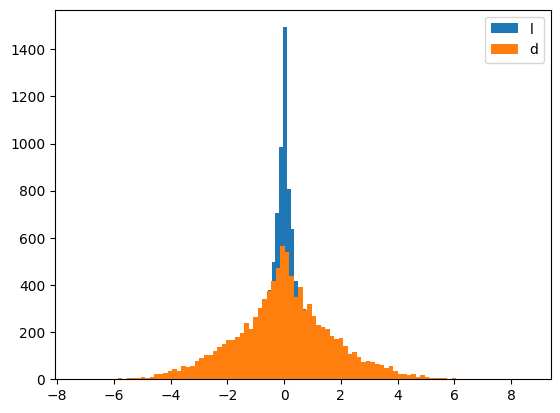

In [1]:
from scripts.noise_schedule import NoiseSchedule
import numpy as np
import torch
import matplotlib.pyplot as plt

schedule = NoiseSchedule(1000)
noise_level_stddev=0.5
angle_noise_level_stddev=np.pi / 3
bins = 100

scene_noise_levels_l = []
scene_noise_levels_d = []
scene_angle_noise_levels_l = []
scene_angle_noise_levels_d = []
for _ in range(10000):
    scene_noise_level = abs(np.random.normal(loc=0.0, scale=noise_level_stddev))
    scene_angle_noise_level = abs(np.random.normal(loc=0.0, scale=angle_noise_level_stddev))

    scene_noise_level = np.random.normal(loc=0.0, scale=scene_noise_level)
    scene_angle_noise_level = np.random.normal(loc=0.0, scale=scene_angle_noise_level)

    scene_noise_levels_l.append(scene_noise_level)
    scene_angle_noise_levels_l.append(scene_angle_noise_level)

    t = torch.randint(0, schedule.timesteps, (1,), dtype=torch.long)
    noise_level = schedule.sqrt_one_minus_alphas_cumprod[t[0]].item() * 2
    scene_noise_level = noise_level_stddev * noise_level
    scene_angle_noise_level = angle_noise_level_stddev * noise_level

    scene_noise_level = np.random.normal(loc=0.0, scale=scene_noise_level)
    scene_angle_noise_level = np.random.normal(loc=0.0, scale=scene_angle_noise_level)

    scene_noise_levels_d.append(scene_noise_level)
    scene_angle_noise_levels_d.append(scene_angle_noise_level)

plt.hist(scene_noise_levels_l, bins=bins)
plt.hist(scene_noise_levels_d, bins=bins)
plt.legend(["l", "d"])
plt.show()

plt.hist(scene_angle_noise_levels_l, bins=bins)
plt.hist(scene_angle_noise_levels_d, bins=bins)
plt.legend(["l", "d"])
plt.show()

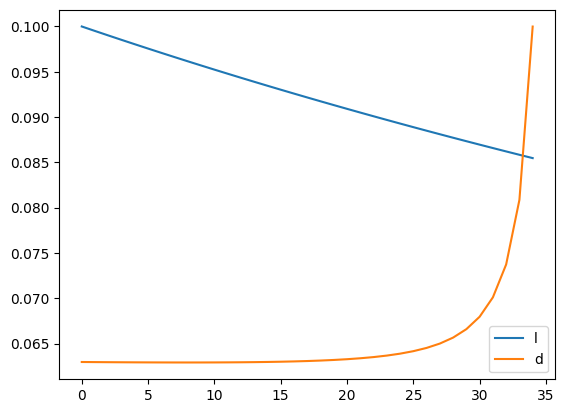

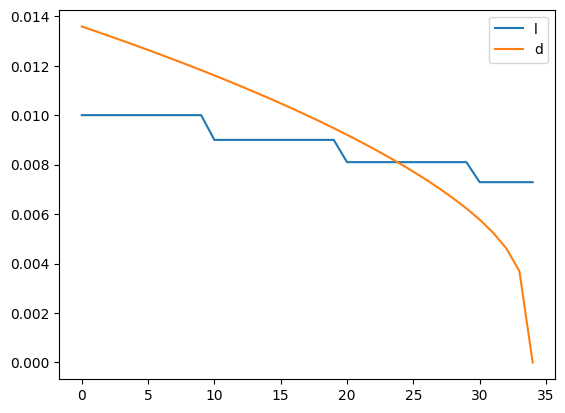

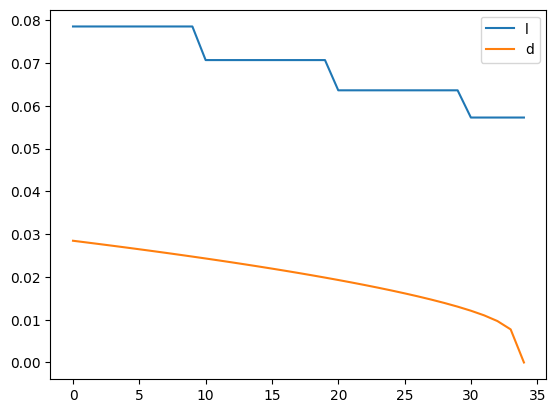

In [4]:
from scripts.noise_schedule import NoiseSchedule
import numpy as np
import torch
import matplotlib.pyplot as plt

schedule = NoiseSchedule(1000)
noise_level_stddev=0.5
angle_noise_level_stddev=np.pi / 3
local_max_iter = 200
step_size0, step_decay = 0.1, 0.005
noise_scale0, noise_decay, noise_drop_freq = 0.01, 0.9, 10

step_sizes_l = []
step_sizes_d = []
noise_scale_l = []
noise_scale_d = []
ang_noise_scale_l = []
ang_noise_scale_d = []

for iter_i in range(local_max_iter):
    step_size =  step_size0 / (1 + step_decay*iter_i) 
    noise_scale = noise_scale0 * noise_decay**(iter_i // noise_drop_freq) # standard deviation
    ang_noise_scale = noise_scale/noise_scale0 * ((np.pi/4)/10)  # noise_scale0=0.01 correspond to (np.pi/4)/10
    step_sizes_l.append(step_size)
    noise_scale_l.append(noise_scale)
    ang_noise_scale_l.append(ang_noise_scale)

    t = torch.LongTensor([local_max_iter - 1 - iter_i])
    sqrt_posterior_variance_t = np.sqrt(schedule.posterior_variance[t].item()) * 0.1
    betas_t = schedule.betas[t].item()
    sqrt_one_minus_alphas_cumprod_t = schedule.sqrt_one_minus_alphas_cumprod[t].item()
    step_size = betas_t / sqrt_one_minus_alphas_cumprod_t * 10.0
    noise_scale = noise_level_stddev * sqrt_posterior_variance_t
    ang_noise_scale = angle_noise_level_stddev * sqrt_posterior_variance_t
    step_sizes_d.append(step_size)
    noise_scale_d.append(noise_scale)
    ang_noise_scale_d.append(ang_noise_scale)

plt.plot(step_sizes_l)
plt.plot(step_sizes_d)
plt.legend(["l", "d"])
plt.show()

plt.plot(noise_scale_l)
plt.plot(noise_scale_d)
plt.legend(["l", "d"])
plt.show()

plt.plot(ang_noise_scale_l)
plt.plot(ang_noise_scale_d)
plt.legend(["l", "d"])
plt.show()

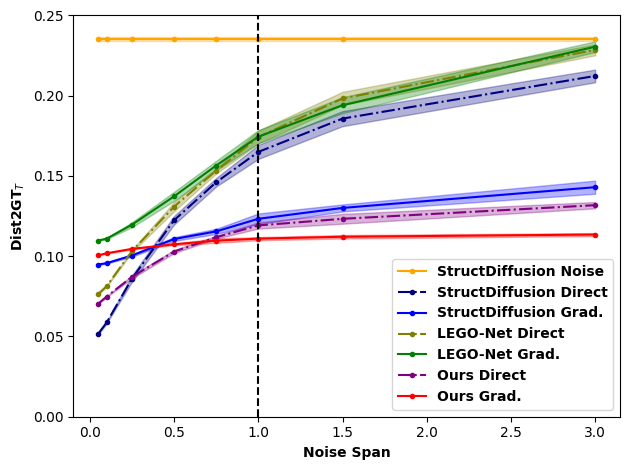

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight'] = "bold"
noise_levels=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 3.0]

all_emd2gts = np.array([0.23527298421198534] * len(noise_levels))
confidence_interval = np.array([0.0010910383562883598] * len(noise_levels))
lower_bound = all_emd2gts - confidence_interval
upper_bound = all_emd2gts + confidence_interval
plt.plot(noise_levels, all_emd2gts, '.-', color="orange")
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=0.3, color="orange")
all_emd2gts=[[0.05171412841128059, 0.0, 0.09483648597660481, 0.09484633474956838], [0.05872438383477454, 0.0, 0.09575878890084547, 0.09571716032279351], [0.08605162948232524, 0.0, 0.10046263549014896, 0.10044136433362402], [0.12242113198038784, 0.0, 0.11066905354827021, 0.11070749518319196], [0.1460914840724316, 0.0, 0.11555134058889398, 0.11547941418437088], [0.1649858105078287, 0.0, 0.12323016654698564, 0.12331147178065012], [0.18575087771829954, 0.0, 0.13009083630016066, 0.13009515779823205], [0.21233410847943884, 0.0, 0.1431595219608055, 0.14301642584374472]]
all_ang2gts=[[0.00036357439225981206, 0.0, 0.00035319333327539385, 0.00035388179072855724], [0.0007489205369365093, 0.0, 0.0003606774898039662, 0.00036096041664717196], [0.0029204934642726513, 0.0, 0.0007711897079952128, 0.0007712965338830168], [0.011808546344443805, 0.0, 0.0032009972725754086, 0.0031308340607348857], [0.02250102310618481, 0.0, 0.006296022008173349, 0.00631611579792421], [0.035355590326657124, 0.0, 0.010593629882475242, 0.010600718252393277], [0.051131234091241075, 0.0, 0.014037327027943039, 0.013952347420613798], [0.07270548965289622, 0.0, 0.02298710191400008, 0.022319802463228493]]
all_perobj_distmoveds=[[0.06697648719600471, 0.0, 0.10862521597466664, 0.10863512706248168], [0.09590358144089402, 0.0, 0.135607111437574, 0.13560796851663484], [0.17765463747451146, 0.0, 0.22391916002674356, 0.22392185743123533], [0.26066042869350886, 0.0, 0.3180119212544287, 0.3180525997018078], [0.30220197799399184, 0.0, 0.3668814122977554, 0.3668600615845518], [0.32373106299598875, 0.0, 0.3944744191612285, 0.3944943877989623], [0.3562615806290018, 0.0, 0.4349481339841031, 0.43497663606089293], [0.3869206888086913, 0.0, 0.47342596100057566, 0.4734719396844499]]
all_iou25s=[[0.6628861003861004, 0.0, 0.48788610038610036, 0.4876447876447876], [0.632915057915058, 0.0, 0.4835907335907336, 0.48499034749034753], [0.5512548262548262, 0.0, 0.4720559845559845, 0.47253861003861], [0.45970077220077227, 0.0, 0.45830115830115836, 0.45970077220077216], [0.4061293436293436, 0.0, 0.4446428571428571, 0.4446428571428571], [0.36201737451737453, 0.0, 0.4342181467181467, 0.4338803088803089], [0.31751930501930503, 0.0, 0.4169401544401544, 0.41674710424710426], [0.27229729729729735, 0.0, 0.39826254826254825, 0.3986969111969112]]
all_iou50s=[[0.47244208494208495, 0.0, 0.27446911196911195, 0.27297297297297296], [0.4467181467181467, 0.0, 0.2748552123552123, 0.275965250965251], [0.3546814671814672, 0.0, 0.2697393822393822, 0.2697876447876448], [0.2725868725868726, 0.0, 0.25506756756756754, 0.25574324324324327], [0.22562741312741313, 0.0, 0.24715250965250965, 0.2471042471042471], [0.1888030888030888, 0.0, 0.23672779922779918, 0.23595559845559846], [0.15709459459459457, 0.0, 0.21583011583011583, 0.21529922779922778], [0.12292471042471043, 0.0, 0.19724903474903474, 0.19715250965250963]]
all_emd2gts = np.array(all_emd2gts)
confidence_interval = np.array([[0.0006301362340676364, 0.0, 0.000407285548277089, 0.00039598981439305117], [0.0004893469402265853, 0.0, 0.0002990195025781304, 0.0003066887004795287], [0.001947346337158876, 0.0, 0.0007218598212652443, 0.0007234985332065493], [0.0026935342791761232, 0.0, 0.0012395095562278836, 0.0011977498507781163], [0.002662685579937709, 0.0, 0.001602213473173304, 0.0015917529983875975], [0.004334590101055728, 0.0, 0.0032584485467945282, 0.0033227519625982707], [0.0046997048011079385, 0.0, 0.002089583328237391, 0.0021839772248437622], [0.003963968324986609, 0.0, 0.003820366615386135, 0.00409586891553437]])
lower_bound = all_emd2gts[:, 0] - confidence_interval[:, 0]
upper_bound = all_emd2gts[:, 0] + confidence_interval[:, 0]
plt.plot(noise_levels, all_emd2gts[:, 0], '.-.', color="navy")
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=0.3, color="navy")
lower_bound = all_emd2gts[:, 3] - confidence_interval[:, 3]
upper_bound = all_emd2gts[:, 3] + confidence_interval[:, 3]
plt.plot(noise_levels, all_emd2gts[:, 3], '.-', color="blue")
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=0.3, color="blue")

all_emd2gts=[[0.0765137881097933, 0.0, 0.10978208195628787, 0.10977919738093897], [0.08140869267246294, 0.0, 0.11095964880857126, 0.1109772913549052], [0.1032040540582401, 0.0, 0.11967521719395577, 0.11966218909491429], [0.1309137674597998, 0.0, 0.13726639199458862, 0.1373002561251965], [0.15326026408083532, 0.0, 0.15646973142465, 0.15652489625274152], [0.17418937640310378, 0.0, 0.17431394499540082, 0.17450333121633008], [0.19831329617421997, 0.0, 0.19407323406335278, 0.19408790233772505], [0.22860080850705655, 0.0, 0.23069245227891372, 0.23057930669356147]]
all_ang2gts=[[0.0004314726393869942, 0.0, 0.00034543502484640635, 0.0003461214991909545], [0.0004843667178356636, 0.0, 0.0004580187652990544, 0.00045766575462279264], [0.007062011322486824, 0.0, 0.005380814475616772, 0.005365925921379063], [0.022092359830752615, 0.0, 0.021475703607415263, 0.021495176553169376], [0.04261969902584734, 0.0, 0.04251041179514436, 0.042579479131176254], [0.05741497884779462, 0.0, 0.06396445792594475, 0.06459221990290676], [0.08284034256130904, 0.0, 0.08787458919907128, 0.0878228342470601], [0.11727353041873918, 0.0, 0.1381714632269488, 0.13789173560458412]]
all_perobj_distmoveds=[[0.09170626877965879, 0.0, 0.12313314113304918, 0.12313515266210498], [0.12148056613072744, 0.0, 0.1495909997886118, 0.14960699380510262], [0.209646266930185, 0.0, 0.23597687644294937, 0.23599028585119391], [0.3008120619237512, 0.0, 0.327787359438385, 0.3278071955428569], [0.3562257915120222, 0.0, 0.38495825543488243, 0.3849510479366301], [0.3830176921955695, 0.0, 0.4136266276544795, 0.41363134821553516], [0.41435936075675983, 0.0, 0.44772764013635535, 0.4477443925137578], [0.4576944610294283, 0.0, 0.49239870034247923, 0.4924214728699516]]
all_iou25s=[[0.5367277992277992, 0.0, 0.4220559845559846, 0.42210424710424704], [0.5294401544401545, 0.0, 0.42210424710424715, 0.42118725868725876], [0.47760617760617763, 0.0, 0.4035714285714286, 0.4037644787644788], [0.4260617760617761, 0.0, 0.3846042471042471, 0.38484555984555985], [0.3838320463320463, 0.0, 0.3611003861003861, 0.36124517374517373], [0.3453667953667954, 0.0, 0.3456081081081081, 0.345511583011583], [0.3079150579150579, 0.0, 0.32432432432432434, 0.32384169884169883], [0.25868725868725867, 0.0, 0.2853281853281853, 0.2858590733590734]]
all_iou50s=[[0.3378378378378379, 0.0, 0.2353764478764479, 0.23566602316602317], [0.33267374517374515, 0.0, 0.2349903474903475, 0.23494208494208496], [0.2826254826254826, 0.0, 0.22277992277992276, 0.22335907335907335], [0.2417953667953668, 0.0, 0.21307915057915058, 0.21346525096525096], [0.20714285714285713, 0.0, 0.19816602316602316, 0.19797297297297298], [0.17784749034749034, 0.0, 0.182480694980695, 0.1826254826254826], [0.14860038610038612, 0.0, 0.1708011583011583, 0.16988416988416988], [0.11761583011583013, 0.0, 0.14377413127413127, 0.14348455598455598]]
all_emd2gts = np.array(all_emd2gts)
confidence_interval = np.array([[0.0004537073876269714, 0.0, 0.00022005374371115064, 0.0002525354734928047], [0.0004404722995010028, 0.0, 0.00031922799230181087, 0.00031177481878042715], [0.000745380740074475, 0.0, 0.0015604668514449865, 0.0015576316692003363], [0.002858517344166753, 0.0, 0.002820931053832952, 0.002843829035752744], [0.001649173466871603, 0.0, 0.0025617126569179105, 0.002939688685393058], [0.004062000423316798, 0.0, 0.004085083990399016, 0.004070654924619447], [0.004142402740682, 0.0, 0.005023557249738583, 0.0049468352449828995], [0.003424154823885359, 0.0, 0.0034621559643962527, 0.0033246299434385768]])
lower_bound = all_emd2gts[:, 0] - confidence_interval[:, 0]
upper_bound = all_emd2gts[:, 0] + confidence_interval[:, 0]
plt.plot(noise_levels, all_emd2gts[:, 0], '.-.', color="olive")
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=0.3, color="olive")
lower_bound = all_emd2gts[:, 3] - confidence_interval[:, 3]
upper_bound = all_emd2gts[:, 3] + confidence_interval[:, 3]
plt.plot(noise_levels, all_emd2gts[:, 3], '.-', color="green")
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=0.3, color="green")

all_emd2gts=[[0.07047249618848159, 0.0, 0.10059725599365883, 0.10060684652196641], [0.07487542807072867, 0.0, 0.10185036387840589, 0.1018592726852298], [0.08717254160656507, 0.0, 0.10457094751346689, 0.10458286130402553], [0.10290695345321368, 0.0, 0.10741988839112356, 0.10742685863991253], [0.1118292075137007, 0.0, 0.1097138482341868, 0.10971368486527178], [0.11918486318299737, 0.0, 0.11096468365795406, 0.11096559588824588], [0.1233192630775167, 0.0, 0.11211932085323317, 0.11213617614472757], [0.1318056011478129, 0.0, 0.11350607121400598, 0.11350927098229865]]
all_ang2gts=[[0.00014913031498256898, 0.0, 0.00013339879411995308, 0.00013365429422090397], [0.0001583467643795573, 0.0, 0.0001384144509158721, 0.00013889113192091883], [0.0025476846554309037, 0.0, 0.00022559103788753466, 0.0002253200978893963], [0.00530251072079057, 0.0, 0.0007729096404238938, 0.0007723171327794047], [0.007806822423764523, 0.0, 0.0011228526015515077, 0.0011269779309548262], [0.010022471632113013, 0.0, 0.0018529528411565157, 0.001853529016344818], [0.01172056853578316, 0.0, 0.002043129016917279, 0.0020432259394119385], [0.012653079232111975, 0.0, 0.00221824676503857, 0.002177989398377279]]
all_perobj_distmoveds=[[0.0869746877417388, 0.0, 0.1142674251524669, 0.11427345083926058], [0.11958767417069929, 0.0, 0.1424291308163578, 0.1424350127203408], [0.20917043222233822, 0.0, 0.22748412841127325, 0.2274800576047261], [0.3140377165866771, 0.0, 0.33035796043027926, 0.33035364226036423], [0.36618227496899153, 0.0, 0.3812144564500834, 0.38121440969470066], [0.3997827946210625, 0.0, 0.41367090289719294, 0.41367743380048266], [0.4413523087712389, 0.0, 0.45415729002127236, 0.4541568035325584], [0.4920696672501347, 0.0, 0.5026150097406508, 0.5026034137714313]]
all_iou25s=[[0.613899613899614, 0.0, 0.4745173745173745, 0.4745656370656371], [0.5923262548262548, 0.0, 0.4696428571428572, 0.46872586872586874], [0.5626930501930503, 0.0, 0.4686293436293436, 0.469449806949807], [0.5178571428571428, 0.0, 0.4645752895752896, 0.46491312741312746], [0.49527027027027026, 0.0, 0.4611486486486487, 0.46100386100386104], [0.47668918918918923, 0.0, 0.45950772200772205, 0.4594111969111969], [0.46558880308880307, 0.0, 0.45709459459459456, 0.4555984555984557], [0.44073359073359075, 0.0, 0.45082046332046327, 0.45120656370656376]]
all_iou50s=[[0.40535714285714286, 0.0, 0.2702702702702703, 0.2700772200772201], [0.3852799227799228, 0.0, 0.2648648648648649, 0.2652992277992278], [0.34961389961389966, 0.0, 0.25796332046332043, 0.2574324324324324], [0.30492277992277994, 0.0, 0.2481177606177606, 0.2480212355212355], [0.2829633204633205, 0.0, 0.24179536679536678, 0.24121621621621622], [0.2623552123552123, 0.0, 0.23701737451737453, 0.2372586872586872], [0.25106177606177604, 0.0, 0.2317084942084942, 0.23204633204633204], [0.23532818532818536, 0.0, 0.2291988416988417, 0.2295366795366795]]
all_emd2gts = np.array(all_emd2gts)
confidence_interval = np.array([[0.00034980012813347507, 0.0, 0.00021101282550379873, 0.00021022891288741903], [0.0002711570443261335, 0.0, 0.0002479075978161255, 0.00023541922947612439], [0.0009497879458643915, 0.0, 0.0004005491876661097, 0.0003968279358648078], [0.000987264460600339, 0.0, 0.0005343957833876426, 0.0005285183509319991], [0.0008633815451079709, 0.0, 0.0014029579056338522, 0.0014005895964938778], [0.001965241550081828, 0.0, 0.0009702310135406576, 0.0009678606109516604], [0.0030673635490962993, 0.0, 0.0010961817305259437, 0.0010937564286536462], [0.0019761741172180237, 0.0, 0.0009270487352656926, 0.0009384450799189655]])
lower_bound = all_emd2gts[:, 0] - confidence_interval[:, 0]
upper_bound = all_emd2gts[:, 0] + confidence_interval[:, 0]
plt.plot(noise_levels, all_emd2gts[:, 0], '.-.', color="purple")
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=0.3, color="purple")
lower_bound = all_emd2gts[:, 3] - confidence_interval[:, 3]
upper_bound = all_emd2gts[:, 3] + confidence_interval[:, 3]
plt.plot(noise_levels, all_emd2gts[:, 3], '.-', color="red")
plt.fill_between(noise_levels, lower_bound, upper_bound, alpha=0.3, color="red")

plt.axvline(x=1, linestyle='dashed', color='k')
plt.legend(prop={'weight': 'bold'}, handles=[plt.gca().lines[0], plt.gca().lines[1], plt.gca().lines[2], plt.gca().lines[3], plt.gca().lines[4], plt.gca().lines[5], plt.gca().lines[6]], labels=["StructDiffusion Noise", "StructDiffusion Direct", "StructDiffusion Grad.", "LEGO-Net Direct", "LEGO-Net Grad.", "Ours Direct", "Ours Grad."])
plt.xlabel("Noise Span")
plt.ylabel("Dist2GT$_T$")
plt.ylim(0.0, 0.25)
fig.tight_layout()
# fig.savefig('noise_span.pdf', bbox_inches='tight')

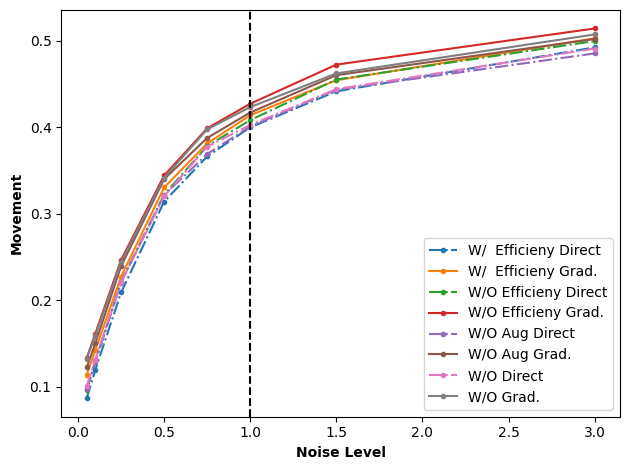

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure()
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight'] = "bold"
noise_levels=[0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 3.0]

all_emd2gts=[[0.07047249618848159, 0.0, 0.10059725599365883, 0.10060684652196641], [0.07487542807072867, 0.0, 0.10185036387840589, 0.1018592726852298], [0.08717254160656507, 0.0, 0.10457094751346689, 0.10458286130402553], [0.10290695345321368, 0.0, 0.10741988839112356, 0.10742685863991253], [0.1118292075137007, 0.0, 0.1097138482341868, 0.10971368486527178], [0.11918486318299737, 0.0, 0.11096468365795406, 0.11096559588824588], [0.1233192630775167, 0.0, 0.11211932085323317, 0.11213617614472757], [0.1318056011478129, 0.0, 0.11350607121400598, 0.11350927098229865]]
all_ang2gts=[[0.00014913031498256898, 0.0, 0.00013339879411995308, 0.00013365429422090397], [0.0001583467643795573, 0.0, 0.0001384144509158721, 0.00013889113192091883], [0.0025476846554309037, 0.0, 0.00022559103788753466, 0.0002253200978893963], [0.00530251072079057, 0.0, 0.0007729096404238938, 0.0007723171327794047], [0.007806822423764523, 0.0, 0.0011228526015515077, 0.0011269779309548262], [0.010022471632113013, 0.0, 0.0018529528411565157, 0.001853529016344818], [0.01172056853578316, 0.0, 0.002043129016917279, 0.0020432259394119385], [0.012653079232111975, 0.0, 0.00221824676503857, 0.002177989398377279]]
all_perobj_distmoveds=[[0.0869746877417388, 0.0, 0.1142674251524669, 0.11427345083926058], [0.11958767417069929, 0.0, 0.1424291308163578, 0.1424350127203408], [0.20917043222233822, 0.0, 0.22748412841127325, 0.2274800576047261], [0.3140377165866771, 0.0, 0.33035796043027926, 0.33035364226036423], [0.36618227496899153, 0.0, 0.3812144564500834, 0.38121440969470066], [0.3997827946210625, 0.0, 0.41367090289719294, 0.41367743380048266], [0.4413523087712389, 0.0, 0.45415729002127236, 0.4541568035325584], [0.4920696672501347, 0.0, 0.5026150097406508, 0.5026034137714313]]
all_iou25s=[[0.613899613899614, 0.0, 0.4745173745173745, 0.4745656370656371], [0.5923262548262548, 0.0, 0.4696428571428572, 0.46872586872586874], [0.5626930501930503, 0.0, 0.4686293436293436, 0.469449806949807], [0.5178571428571428, 0.0, 0.4645752895752896, 0.46491312741312746], [0.49527027027027026, 0.0, 0.4611486486486487, 0.46100386100386104], [0.47668918918918923, 0.0, 0.45950772200772205, 0.4594111969111969], [0.46558880308880307, 0.0, 0.45709459459459456, 0.4555984555984557], [0.44073359073359075, 0.0, 0.45082046332046327, 0.45120656370656376]]
all_iou50s=[[0.40535714285714286, 0.0, 0.2702702702702703, 0.2700772200772201], [0.3852799227799228, 0.0, 0.2648648648648649, 0.2652992277992278], [0.34961389961389966, 0.0, 0.25796332046332043, 0.2574324324324324], [0.30492277992277994, 0.0, 0.2481177606177606, 0.2480212355212355], [0.2829633204633205, 0.0, 0.24179536679536678, 0.24121621621621622], [0.2623552123552123, 0.0, 0.23701737451737453, 0.2372586872586872], [0.25106177606177604, 0.0, 0.2317084942084942, 0.23204633204633204], [0.23532818532818536, 0.0, 0.2291988416988417, 0.2295366795366795]]
all_perobj_distmoveds = np.array(all_perobj_distmoveds)
plt.plot(noise_levels, all_perobj_distmoveds[:, 0], '.-.')
plt.plot(noise_levels, all_perobj_distmoveds[:, 3], '.-')

all_emd2gts=[[0.08212448336714975, 0.0, 0.12119350937260527, 0.1212062435426153], [0.08802963976086292, 0.0, 0.12287253285514561, 0.12287311091019497], [0.10778749112082034, 0.0, 0.13010339503803395, 0.13009523635488357], [0.1322704031533654, 0.0, 0.14058155367660952, 0.1405808845367275], [0.14887852919334074, 0.0, 0.14882008967719304, 0.1488025109186573], [0.15959167555798429, 0.0, 0.15540517984316907, 0.15539649361197355], [0.17026104820636564, 0.0, 0.1623695054519338, 0.16238516556252003], [0.18217099863840025, 0.0, 0.17018183556273822, 0.1701903997156484]]
all_ang2gts=[[0.0002856915865910665, 0.0, 0.00026646837528181204, 0.0002657894760168389], [0.00040888143820790393, 0.0, 0.0002690840194005706, 0.00026961343011791143], [0.0019333952031725193, 0.0, 0.00033670411363323, 0.0003457503984339252], [0.0059511776683779695, 0.0, 0.0011694961937008517, 0.0011709056114023498], [0.00886283235709383, 0.0, 0.0018104004212586397, 0.0018108219398958916], [0.009793324921898505, 0.0, 0.0017392327530807844, 0.0017368086910947273], [0.012087147592775176, 0.0, 0.001734840415700608, 0.0017332230529347216], [0.01612986169798075, 0.0, 0.0034620034224254934, 0.003468677546493517]]
all_perobj_distmoveds=[[0.09631577117501774, 0.0, 0.13319438617237261, 0.1331986421193176], [0.12941412426421944, 0.0, 0.16146299473896192, 0.16146294994182064], [0.2216780199018189, 0.0, 0.2467364155186719, 0.2467304761452397], [0.32220603814135335, 0.0, 0.34415824833519776, 0.34415927173336425], [0.37817088395399473, 0.0, 0.3986198668205919, 0.39861138434966437], [0.40808969210444535, 0.0, 0.4269811988532841, 0.426990125103499], [0.4549703216097658, 0.0, 0.4721787965256762, 0.4721915134954509], [0.4994080339645105, 0.0, 0.5139067217997497, 0.5138999016781642]]
all_iou25s=[[0.5203185328185327, 0.0, 0.40936293436293436, 0.40970077220077217], [0.5044884169884171, 0.0, 0.4088803088803089, 0.40883204633204634], [0.4578185328185328, 0.0, 0.39367760617760617, 0.39420849420849424], [0.405984555984556, 0.0, 0.37987451737451733, 0.38059845559845557], [0.3694980694980695, 0.0, 0.3696911196911197, 0.3698841698841699], [0.3518339768339768, 0.0, 0.360472972972973, 0.36052123552123555], [0.3333494208494209, 0.0, 0.34802123552123554, 0.3486003861003861], [0.30622586872586877, 0.0, 0.33518339768339767, 0.3353764478764479]]
all_iou50s=[[0.3276544401544402, 0.0, 0.20723938223938224, 0.20733590733590734], [0.30583976833976834, 0.0, 0.2036196911196911, 0.2038127413127413], [0.2525096525096525, 0.0, 0.19309845559845562, 0.19309845559845562], [0.20974903474903472, 0.0, 0.18228764478764478, 0.18252895752895754], [0.17471042471042472, 0.0, 0.17519305019305023, 0.17524131274131274], [0.16254826254826255, 0.0, 0.1679054054054054, 0.167519305019305], [0.1494208494208494, 0.0, 0.1602799227799228, 0.1597007722007722], [0.13334942084942086, 0.0, 0.15222007722007722, 0.15222007722007722]]
all_perobj_distmoveds = np.array(all_perobj_distmoveds)
plt.plot(noise_levels, all_perobj_distmoveds[:, 0], '.-.')
plt.plot(noise_levels, all_perobj_distmoveds[:, 3], '.-')

all_emd2gts=[[0.08200434483751909, 0.0, 0.10910812194696777, 0.10909503262848741], [0.08535148608594409, 0.0, 0.11002422626496437, 0.110029603362547], [0.09658415108798205, 0.0, 0.11196197291455692, 0.11196171789481361], [0.11522436989542328, 0.0, 0.11418722453875843, 0.11419433429918083], [0.12181881649908607, 0.0, 0.11500959767723959, 0.11503047875857823], [0.12657184145882666, 0.0, 0.11582205902903435, 0.11584124935658802], [0.13451989414738114, 0.0, 0.11778260664720938, 0.11779845615626558], [0.141320724816804, 0.0, 0.11833245484515084, 0.1183014234475612]]
all_ang2gts=[[0.0003287070882829729, 0.0, 0.0005189230921382415, 0.0005081787008526277], [0.0005020660138889504, 0.0, 0.000546866588020852, 0.000545177769127069], [0.002248254629676133, 0.0, 0.0007842187650845076, 0.0008102603422835113], [0.008433652446078058, 0.0, 0.0014805299232202684, 0.001467587408036381], [0.009436247597374678, 0.0, 0.0015681560170185713, 0.0016125430041965185], [0.012439844351881342, 0.0, 0.0021917753969558544, 0.0021851812682721016], [0.015434892117085198, 0.0, 0.0028273019878299827, 0.0028152434773983095], [0.01512141448082627, 0.0, 0.00320689375826261, 0.0031823685453282085]]
all_perobj_distmoveds=[[0.09713837958019725, 0.0, 0.12247020418389598, 0.12246862948954125], [0.12843385236558147, 0.0, 0.1503568405531063, 0.15036132882647885], [0.22058423453049597, 0.0, 0.23959637832517755, 0.23960452876899058], [0.3215810301311914, 0.0, 0.33989947556038064, 0.33990748356033984], [0.3690169534675641, 0.0, 0.3875131718598614, 0.3875248331184632], [0.4008919423290334, 0.0, 0.4168891697682815, 0.41687801317049733], [0.4431978576189185, 0.0, 0.45997827938000907, 0.4599969104565035], [0.48511875149541883, 0.0, 0.5017359383331045, 0.5017452312895241]]
all_iou25s=[[0.5846525096525096, 0.0, 0.46805019305019313, 0.46694015444015446], [0.570511583011583, 0.0, 0.4663610038610038, 0.46597490347490345], [0.5366312741312742, 0.0, 0.4648648648648649, 0.4652992277992277], [0.49165057915057914, 0.0, 0.46018339768339767, 0.4591216216216217], [0.4752413127413127, 0.0, 0.46389961389961387, 0.46414092664092665], [0.4592181467181467, 0.0, 0.45916988416988413, 0.4588803088803089], [0.44406370656370653, 0.0, 0.4569015444015444, 0.4563223938223938], [0.42847490347490347, 0.0, 0.4570463320463321, 0.4559362934362934]]
all_iou50s=[[0.36626447876447876, 0.0, 0.2694015444015444, 0.2695945945945946], [0.35458494208494207, 0.0, 0.2656853281853282, 0.266554054054054], [0.3192084942084942, 0.0, 0.2577702702702703, 0.25825289575289573], [0.27697876447876446, 0.0, 0.24917953667953663, 0.2483590733590734], [0.2583011583011583, 0.0, 0.24946911196911198, 0.2506274131274131], [0.24720077220077216, 0.0, 0.24560810810810813, 0.24594594594594596], [0.23532818532818536, 0.0, 0.23774131274131274, 0.23846525096525095], [0.2201737451737452, 0.0, 0.2372104247104247, 0.23793436293436293]]
all_perobj_distmoveds = np.array(all_perobj_distmoveds)
plt.plot(noise_levels, all_perobj_distmoveds[:, 0], '.-.')
plt.plot(noise_levels, all_perobj_distmoveds[:, 3], '.-')

all_emd2gts=[[0.08847888570023135, 0.0, 0.12182405499858799, 0.12182266514095046], [0.09444497584719651, 0.0, 0.12409024695648933, 0.12408812792400666], [0.1140258227464204, 0.0, 0.13036637653502217, 0.1303591417653886], [0.14209378913838294, 0.0, 0.14211173232992821, 0.14211442358850543], [0.15968591809214439, 0.0, 0.15154410165002913, 0.1515427568133186], [0.1665463202040101, 0.0, 0.1539427927179802, 0.15394717478139128], [0.17563257587007253, 0.0, 0.1598996521472794, 0.15986014657445707], [0.19138418615535888, 0.0, 0.1685087216793471, 0.16847721782197295]]
all_ang2gts=[[0.00018284356892755467, 0.0, 0.00017116054613579602, 0.0001713451191576571], [0.0003021096191325022, 0.0, 0.00017505563301904937, 0.000175259988572076], [0.0024052804339980464, 0.0, 0.00036048851480221676, 0.0003602455596749557], [0.007974902024052415, 0.0, 0.0006031580380484021, 0.0006041376693133769], [0.009202144387505934, 0.0, 0.0014023626719923156, 0.0013934141852881975], [0.013655686255600485, 0.0, 0.001346355655568293, 0.0013830756227699303], [0.014157609447167102, 0.0, 0.0019234822678454659, 0.0019326695181131463], [0.016756331796971863, 0.0, 0.002998765075475464, 0.0029647046186338194]]
all_perobj_distmoveds=[[0.1008698010404336, 0.0, 0.13283066943599148, 0.13282893302510904], [0.13150661479643647, 0.0, 0.15900357295201145, 0.15902133725055664], [0.22094987420113998, 0.0, 0.2443014311114144, 0.24431346551701258], [0.32028970544731844, 0.0, 0.3415540927071178, 0.3415699263516465], [0.3774997762243064, 0.0, 0.3974796530950776, 0.3974838647230953], [0.4025820789175739, 0.0, 0.4230937917574849, 0.4231014106444554], [0.44383912078341997, 0.0, 0.4620104040153712, 0.46203819614647346], [0.49071356894841706, 0.0, 0.5069834477592413, 0.5070094529017546]]
all_iou25s=[[0.5100386100386101, 0.0, 0.40222007722007724, 0.4022683397683398], [0.4884169884169884, 0.0, 0.39869691119691125, 0.39888996138996136], [0.44387065637065637, 0.0, 0.38778957528957525, 0.3875965250965251], [0.3781370656370656, 0.0, 0.3704633204633205, 0.3707528957528958], [0.3430984555984556, 0.0, 0.3555984555984556, 0.3555019305019306], [0.33663127413127414, 0.0, 0.35144787644787645, 0.3513030888030888], [0.3156853281853282, 0.0, 0.34483590733590735, 0.3445945945945946], [0.2885617760617761, 0.0, 0.3342181467181467, 0.33436293436293435]]
all_iou50s=[[0.3057915057915058, 0.0, 0.2116312741312741, 0.21187258687258687], [0.28672779922779923, 0.0, 0.20506756756756758, 0.20622586872586873], [0.24131274131274133, 0.0, 0.1968629343629344, 0.19666988416988415], [0.18928571428571428, 0.0, 0.18030888030888031, 0.1800675675675676], [0.15902509652509655, 0.0, 0.1661196911196911, 0.1663127413127413], [0.15516409266409265, 0.0, 0.16027992277992278, 0.15965250965250966], [0.1390926640926641, 0.0, 0.1531853281853282, 0.1538127413127413], [0.12123552123552124, 0.0, 0.14633204633204633, 0.1467181467181467]]
all_perobj_distmoveds = np.array(all_perobj_distmoveds)
plt.plot(noise_levels, all_perobj_distmoveds[:, 0], '.-.')
plt.plot(noise_levels, all_perobj_distmoveds[:, 3], '.-')

plt.axvline(x=1, linestyle='dashed', color='k')
plt.legend(["W/  Efficieny Direct", "W/  Efficieny Grad.", "W/O Efficieny Direct", "W/O Efficieny Grad.", "W/O Aug Direct", "W/O Aug Grad.", "W/O Direct", "W/O Grad."])
plt.xlabel("Noise Level")
plt.ylabel("Movement")
fig.tight_layout()

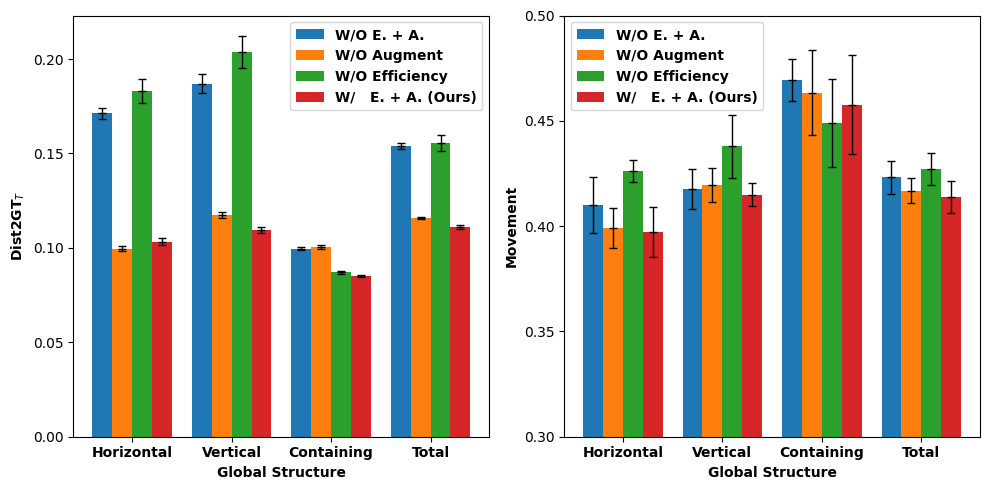

In [7]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight'] = "bold"

ax = fig.add_subplot(1, 2, 1)
categories = ['Horizontal', 'Vertical', 'Containing', 'Total']
regions = ['W/   E. + A. (Ours)', 'W/O Efficiency', 'W/O Augment', 'W/O E. + A.']

values = np.array([
                                [0.10329427477709077, 0.10932623413127689, 0.08515476538775028, 0.11096559588824588], 
                                [0.18305811131223906, 0.20382828238608525, 0.08717317092906213, 0.15539649361197355], 
                                [0.0995930658506548, 0.11717751638564125, 0.10067929815791846, 0.11584124935658802], 
                                [0.17122008090952237, 0.18703780075955273, 0.09964129338605394, 0.15394717478139128]])  # 每个类别在各个分区的值
confidence_intervals = np.array([
                                [0.0020039663478350193, 0.0015010178685310232, 0.0006463687670545045, 0.0009678606109516604],
                                [0.006400613952754082, 0.008629693846821176, 0.0008057301016874372, 0.004220027394544821], 
                                [0.0013447428038471814, 0.0015777038525068266, 0.001068153872811171, 0.000629160464188777], 
                                [0.003062045680350163, 0.005050335594053322, 0.0006671465408239297, 0.0014323210392875973]])  # 每个类别在各个分区的置信度区间

bar_width = 0.2  # 柱状图的宽度
positions = np.arange(len(categories))  # 每个类别的位置

for i in range(len(regions)):
    idx = len(regions) - 1 - i
    ax.bar(positions+(i*bar_width)+bar_width/2, values[idx], width=bar_width, label=regions[idx])
    ax.errorbar(
        positions+(i*bar_width)+bar_width/2,  # x位置
        values[idx],  # y位置
        yerr=[confidence_intervals[idx], confidence_intervals[idx]],  # 置信度区间
        fmt='k_',  # errorbar的样式
        lw=1,  # 线宽
        capsize=3,  # 误差棒的边帽大小
        capthick=1  # 误差棒的边帽线宽
    )
ax.set_xticks(positions+(len(regions)*bar_width)/2, categories, fontweight='bold')
ax.set_yticks([0.0, 0.05, 0.1, 0.15, 0.2])
ax.set_xlabel("Global Structure")
ax.set_ylabel("Dist2GT$_T$")
ax.legend(prop={'weight': 'bold'})

ax = fig.add_subplot(1, 2, 2)
categories = ['Horizontal', 'Vertical', 'Containing', 'Total']
regions = ['W/   E. + A. (Ours)', 'W/O Efficiency', 'W/O Augment', 'W/O E. + A.']

values = np.array([[0.39716187138862413, 0.4149320596113043, 0.45753976715901884, 0.41367743380048266], [0.4262633424798864, 0.43781449187904997, 0.44896775893937246, 0.426990125103499], [0.39910581442364124, 0.41961195893178527, 0.463373052605732, 0.41687801317049733], [0.4098762477077059, 0.4177912368377812, 0.4694421654595834, 0.4231014106444554]])  # 每个类别在各个分区的值
confidence_intervals = np.array([[0.011777834554321045, 0.005618759566170014, 0.02352498234015901, 0.007675162989171813],
                                [0.005227058276601421, 0.014916199355819412, 0.021037557396524537, 0.007679025628010554], 
                                [0.009322262154483368, 0.008151232763051014, 0.020336530484769626, 0.006116627143728667], 
                                [0.013276905327055943, 0.009462986014447842, 0.009929419795120638, 0.007652841727703741]])  # 每个类别在各个分区的置信度区间

bar_width = 0.2  # 柱状图的宽度
positions = np.arange(len(categories))  # 每个类别的位置

for i in range(len(regions)):
    idx = len(regions) - 1 - i
    ax.bar(positions+(i*bar_width)+bar_width/2, values[idx], width=bar_width, label=regions[idx])
    ax.errorbar(
        positions+(i*bar_width)+bar_width/2,  # x位置
        values[idx],  # y位置
        yerr=[confidence_intervals[idx], confidence_intervals[idx]],  # 置信度区间
        fmt='k_',  # errorbar的样式
        lw=1,  # 线宽
        capsize=3,  # 误差棒的边帽大小
        capthick=1  # 误差棒的边帽线宽
    )
ax.set_xticks(positions+(len(regions)*bar_width)/2, categories, fontweight='bold')
ax.set_ylim(0.3, 0.5)
ax.set_yticks([0.3, 0.35, 0.4, 0.45, 0.5])
ax.set_xlabel("Global Structure")
ax.set_ylabel("Movement")
ax.legend(prop={'weight': 'bold'})

# ax = fig.add_subplot(1, 4, 3)
# categories = ['Horizontal', 'Vertical', 'Containing', 'Total']
# regions = ['W/   E + A (Ours)', 'W/O Efficiency', 'W/O Augment', 'W/O E + A']

# values = np.array([[0.5178181818181817, 0.5296450939457202, 0.3711370262390671, 0.4594111969111969], [0.34272727272727266, 0.3045929018789144, 0.3551020408163265, 0.36052123552123555], [0.5030909090909091, 0.5640918580375782, 0.35830903790087465, 0.4588803088803089], [0.35418181818181815, 0.3313152400835073, 0.2880466472303207, 0.3513030888030888]])  # 每个类别在各个分区的值
# confidence_intervals = np.array([[0.007217975724101524, 0.009489200983184528, 0.023821222409114294, 0.005471789689112002],
#                                 [0.01055485474450909, 0.01265418159556723, 0.015305428278025286, 0.0073273293680931354], 
#                                 [0.004549089455707926, 0.010090226282751212, 0.011193209224753616, 0.003934507861426413], 
#                                 [0.013794237627920489, 0.007398766240780518, 0.01249229462718866, 0.003933915805466189]])  # 每个类别在各个分区的置信度区间

# bar_width = 0.2  # 柱状图的宽度
# positions = np.arange(len(categories))  # 每个类别的位置

# for i, region in enumerate(regions):
#     ax.bar(positions+(i*bar_width)+bar_width/2, values[i], width=bar_width, label=region)
#     ax.errorbar(
#         positions+(i*bar_width)+bar_width/2,  # x位置
#         values[i],  # y位置
#         yerr=[confidence_intervals[i], confidence_intervals[i]],  # 置信度区间
#         fmt='k_',  # errorbar的样式
#         lw=1,  # 线宽
#         capsize=3,  # 误差棒的边帽大小
#         capthick=1  # 误差棒的边帽线宽
#     )
# ax.set_xticks(positions+(len(regions)*bar_width)/2, categories)
# ax.set_xlabel("Global Structure")
# ax.set_ylabel("IoU$_{0.25}$")
# ax.legend()

# ax = fig.add_subplot(1, 4, 4)
# categories = ['Horizontal', 'Vertical', 'Containing', 'Total']
# regions = ['W/   E + A (Ours)', 'W/O Efficiency', 'W/O Augment', 'W/O E + A']

# values = np.array([
#                                 [0.2850909090909092, 0.2757828810020877, 0.1784256559766764, 0.2372586872586872], 
#                                 [0.1501818181818182, 0.12171189979123173, 0.14723032069970846, 0.167519305019305], 
#                                 [0.29545454545454547, 0.3037578288100209, 0.17346938775510204, 0.24594594594594596], 
#                                 [0.1592727272727273, 0.12839248434237996, 0.13119533527696794, 0.15965250965250966]])  # 每个类别在各个分区的值
# confidence_intervals = np.array([
#                                 [0.011777552538692117, 0.017939499840451636, 0.014270831779032557, 0.005060438080972239],
#                                 [0.007614687851407969, 0.012862565178078805, 0.005375827671890903, 0.0038228081753499685], 
#                                 [0.009672317147833015, 0.010706372780758313, 0.009536692264604161, 0.0036799995252332625], 
#                                 [0.006885125901367812, 0.007017843972430738, 0.006045609724002252, 0.004054054054054048]])  # 每个类别在各个分区的置信度区间

# bar_width = 0.2  # 柱状图的宽度
# positions = np.arange(len(categories))  # 每个类别的位置

# for i, region in enumerate(regions):
#     ax.bar(positions+(i*bar_width)+bar_width/2, values[i], width=bar_width, label=region)
#     ax.errorbar(
#         positions+(i*bar_width)+bar_width/2,  # x位置
#         values[i],  # y位置
#         yerr=[confidence_intervals[i], confidence_intervals[i]],  # 置信度区间
#         fmt='k_',  # errorbar的样式
#         lw=1,  # 线宽
#         capsize=3,  # 误差棒的边帽大小
#         capthick=1  # 误差棒的边帽线宽
#     )
# ax.set_xticks(positions+(len(regions)*bar_width)/2, categories)
# ax.set_xlabel("Global Structure")
# ax.set_ylabel("IoU$_{0.5}$")
# ax.legend()

fig.tight_layout()
# fig.savefig('ablation_study.pdf', bbox_inches='tight')

In [1]:
import glob, os, copy
import torch
import numpy as np
from scripts.model import Denoiser
from scripts.dataset import TableDataset
from scripts.noise_schedule import NoiseSchedule
from scripts.utils import dist_2_gt
from train import denoise_1scene, adjust_parameters
from omegaconf import OmegaConf
from PIL import Image

data_config1 = OmegaConf.load("configs/YCB_kitchen.yaml")
data_config = OmegaConf.load("configs/YCB_Inpainted.yaml")

dataset = TableDataset(path=[data_config1["dataset_path"], data_config["dataset_path"]], num_class=data_config["num_class"])
schedule = NoiseSchedule(1000)
predict_absolute_pos = 1
predict_absolute_ang = 1

use_position = False
use_time = False
use_text = True
time_form="add"
text_form="word"
denoiser = Denoiser(cla_dim=dataset.cla_dim, max_position=dataset.maxnobj, time_form=time_form, text_form=text_form, mask_types=data_config["mask_types"], use_position = use_position, use_time = use_time, use_text = use_text, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)
if use_text:
    if text_form == "word":
        cond = None
        un_cond = None
    elif text_form == "sentence":
        # cond = ['Knives and forks are placed on the same side of the plates, while four plates are placed horizontally in a row.']
        cond = denoiser.encode_cond(cond, input.device)
        un_cond = denoiser.encode_cond(input.shape[0] * [""], input.device)
        word = None
else:
    cond = None
    un_cond = None
    word = None

for old_best_checkpoint in glob.glob(os.path.join("./logs/YCB_kitchen_YCB_Inpainted/0302_165015_922__FTFFFT_", "best*")):
    # checkpoint = torch.load(old_best_checkpoint, map_location="cuda:0")
    checkpoint = torch.load(old_best_checkpoint, map_location="cpu")
    break
denoiser.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

tensor(0.0026, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([[0.0027, 0.0033, 0.0030, 0.0025, 0.0015, 0.0030, 0.1431, 0.1431, 0.1431,
         0.1431, 0.1431, 0.1431]], dtype=torch.float64,
       grad_fn=<MeanBackward1>)
['forks', 'forks', 'knives', 'knives', 'plates', 'plates']
0.3998947434637638 0.21961637139083198 3.2337276907268286e-05 0.3333333333333333 0.0
0.4985089294043639 0.4495108048670331 0.0001421960135847833 0.0 0.0
tensor(0.0021, dtype=torch.float64, grad_fn=<DivBackward0>)
tensor([[2.5320e-03, 3.3861e-03, 3.0649e-04, 3.6532e-01, 3.6532e-01, 3.6532e-01,
         3.6532e-01, 3.6532e-01, 3.6532e-01, 3.6532e-01, 3.6532e-01, 3.6532e-01]],
       dtype=torch.float64, grad_fn=<MeanBackward1>)
['cans', 'cans', 'bananas']
1.0328255560137 0.07906570540587546 2.3328021729144646e-06 0.3333333333333333 0.3333333333333333
0.6364689348336693 0.5929912496246246 1.6277417586955483e-05 0.0 0.0


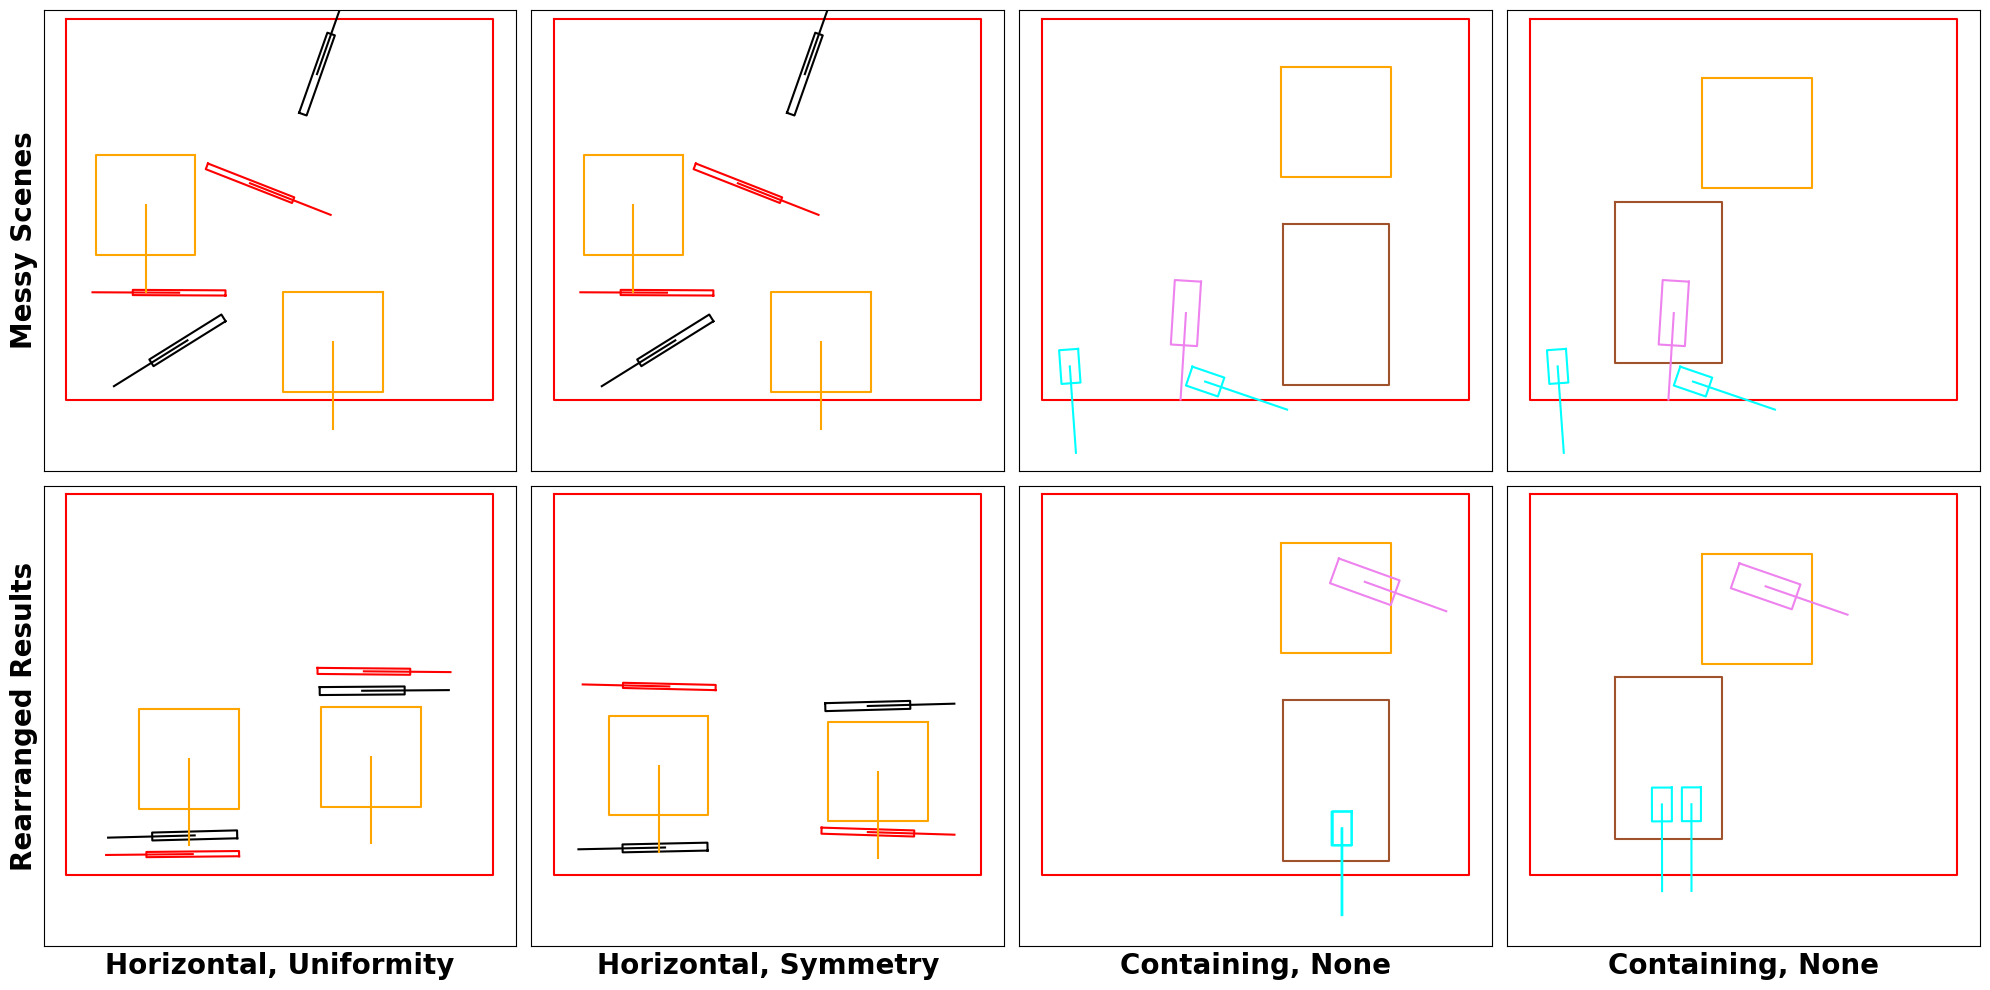

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from scripts.utils import visual_noise, visual_noise_denoise
import random

noise_level_stddev=1.0
angle_noise_level_stddev=np.pi / 3
# OUTPUT_PATH = "qualitive"
# folder = "local"
# os.makedirs(os.path.join(OUTPUT_PATH, folder), exist_ok=True)
fig = plt.figure(figsize=(20, 10))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight'] = "bold"
matplotlib.rcParams['axes.labelsize'] = 20
category = ["forks", "knives", "spoons", "plates", "bowls", "mugs", "cups", "cans", "boxes", "bottles", "bananas", "berries", "mask", "table"]

seed = 53
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

t = torch.randint(200, schedule.timesteps, (1,), dtype=torch.long)
input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, random_idx=np.array([330]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition="test", no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=True, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
input = torch.tensor(input)
mask = torch.tensor(mask)
word = torch.tensor(word)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)
mask_padding_mask = torch.tensor(mask_padding_mask)

args = {}
args["device"] = input.device
args['predict_absolute_pos'] = predict_absolute_pos
args['predict_absolute_ang'] = predict_absolute_ang
args['train_pos_noise_level_stddev'] = noise_level_stddev
args['train_ang_noise_level_stddev'] = angle_noise_level_stddev

# word = torch.LongTensor([[1, 2]])
# cond_scale_guidance = 2.0
cond_scale_guidance = 1.0
adjust_parameters(train = False)
denoiser.eval()
new_mask = mask
# new_mask = torch.tensor([
#     [bbox_y-0.1, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[0]
#     ]).unsqueeze(0)
# new_mask = torch.tensor([
#     [bbox_y-0.2, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[0]
#     ]).unsqueeze(0)
# target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
# t = torch.LongTensor([200])

pred = denoiser(input, padding_mask, mask, mask_padding_mask, t, word=word, condition=cond, un_condition=un_cond, cond_scale_guidance=cond_scale_guidance)
for scene in range(input.shape[0]):
    nobject = padding_mask[scene] == 0
    if scene == 0:
        loss = torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
    else:
        loss += torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
print(loss / input.shape[0])
loss = torch.nn.MSELoss(reduction="none")(pred, labels) + 0.07 * torch.nn.L1Loss(reduction="none")(pred, labels)
# print(torch.mean(loss, dim=[1, 2]))
print(torch.mean(loss, dim=2))

idx = 0
file = clean_scenepaths[idx].replace("pt", "png")
image = Image.open(file).convert("P")
w, h = image.size
nobj, cla_idx = TableDataset.parse_cla(input[idx, :, 6:].numpy())
nmask, _ = TableDataset.parse_cla(mask[idx, :, 6:].numpy())
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

# def update(tr):
#     plt.cla()
#     visual_noise(clean_scenepaths[idx], traj_to_return[tr], padding_mask[idx], target_bbox=target_bbox)
#     # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[tr], labels[idx], padding_mask[idx], target_bbox=target_bbox)

# target_bbox=(-0.3, -0.3, 0.6, 1.2)
# guidance_scale = 3.0
with torch.no_grad():
    traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, cond, un_cond, word, args, "grad_noise", input.device, denoiser, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
    emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

ax = fig.add_subplot(2, 4, 1)
visual_noise(clean_scenepaths[idx], traj_to_return[0], padding_mask[idx], target_bbox=target_bbox)
ax.set_ylabel("Messy Scenes")
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[0], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[0][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "messy1.pt"))

ax = fig.add_subplot(2, 4, 2)
visual_noise(clean_scenepaths[idx], traj_to_return[0], padding_mask[idx], target_bbox=target_bbox)
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[0], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[0][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "messy2.pt"))

ax = fig.add_subplot(2, 4, 5)
visual_noise(clean_scenepaths[idx], traj_to_return[-1], padding_mask[idx], target_bbox=target_bbox)
ax.set_xlabel("Horizontal, Uniformity")
ax.set_ylabel("Rearranged Results")
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[-1][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "rearrange1.pt"))

word = torch.LongTensor([[2, 2]])
with torch.no_grad():
    traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, cond, un_cond, word, args, "grad_noise", input.device, denoiser, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
    emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

ax = fig.add_subplot(2, 4, 6)
visual_noise(clean_scenepaths[idx], traj_to_return[-1], padding_mask[idx], target_bbox=target_bbox)
ax.set_xlabel("Horizontal, Symmetry")
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[-1][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "rearrange2.pt"))

seed = 47
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

t = torch.randint(200, schedule.timesteps, (1,), dtype=torch.long)
# input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, random_idx=np.array([1390]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition="train", no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=True, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, random_idx=np.array([1478]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition="train", no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=True, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
input = torch.tensor(input)
mask = torch.tensor(mask)
word = torch.tensor(word)
labels = torch.tensor(labels)
padding_mask = torch.tensor(padding_mask)
mask_padding_mask = torch.tensor(mask_padding_mask)

new_mask = mask
# target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
# t = torch.LongTensor([200])

pred = denoiser(input, padding_mask, mask, mask_padding_mask, t, word=word, condition=cond, un_condition=un_cond, cond_scale_guidance=cond_scale_guidance)
for scene in range(input.shape[0]):
    nobject = padding_mask[scene] == 0
    if scene == 0:
        loss = torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
    else:
        loss += torch.nn.MSELoss()(pred[scene, nobject, :], labels[scene, nobject, :]) + 0.07 * torch.nn.L1Loss()(pred[scene, nobject, :], labels[scene, nobject, :])
print(loss / input.shape[0])
loss = torch.nn.MSELoss(reduction="none")(pred, labels) + 0.07 * torch.nn.L1Loss(reduction="none")(pred, labels)
# print(torch.mean(loss, dim=[1, 2]))
print(torch.mean(loss, dim=2))

idx = 0
file = clean_scenepaths[idx].replace("pt", "png")
image = Image.open(file).convert("P")
w, h = image.size
nobj, cla_idx = TableDataset.parse_cla(input[idx, :, 6:].numpy())
nmask, _ = TableDataset.parse_cla(mask[idx, :, 6:].numpy())
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

# def update(tr):
#     plt.cla()
#     visual_noise(clean_scenepaths[idx], traj_to_return[tr], padding_mask[idx], target_bbox=target_bbox)
#     # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[tr], labels[idx], padding_mask[idx], target_bbox=target_bbox)

# target_bbox=(-0.3, -0.3, 0.6, 1.2)
# guidance_scale = 3.0
with torch.no_grad():
    traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, cond, un_cond, word, args, "grad_noise", input.device, denoiser, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
    emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

ax = fig.add_subplot(2, 4, 3)
visual_noise(clean_scenepaths[idx], traj_to_return[0], padding_mask[idx], target_bbox=target_bbox)
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[0], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[0][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "messy3.pt"))

ax = fig.add_subplot(2, 4, 7)
visual_noise(clean_scenepaths[idx], traj_to_return[-1], padding_mask[idx], target_bbox=target_bbox)
ax.set_xlabel("Containing, None")
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[-1][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "rearrange3.pt"))

new_mask = torch.tensor([
    [bbox_y-0.1, bbox_x-0.7, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[idx]
    ]).unsqueeze(0)
new_mask = torch.tensor([
    [bbox_y+0.05, bbox_x-0.3, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[idx]
    ]).unsqueeze(0)
target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

ax = fig.add_subplot(2, 4, 4)
visual_noise(clean_scenepaths[idx], traj_to_return[0], padding_mask[idx], target_bbox=target_bbox)
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[0], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[0][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "messy4.pt"))

with torch.no_grad():
    traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, cond, un_cond, word, args, "grad_noise", input.device, denoiser, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
    emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

ax = fig.add_subplot(2, 4, 8)
visual_noise(clean_scenepaths[idx], traj_to_return[-1], padding_mask[idx], target_bbox=target_bbox)
ax.set_xlabel("Containing, None")
ax.set_xticks([])
ax.set_yticks([])
# visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
# loc = {}
# loc["size"] = torch.tensor([h, w])
# loc["cla"] = [category[c] for c in cla_idx]
# loc["obj"] = traj_to_return[-1][:nobj, :6]
# loc["mask"] = new_mask[idx][:nmask]
# torch.save(loc, os.path.join(OUTPUT_PATH, folder, "rearrange4.pt"))

fig.tight_layout()
# fig.savefig('qualitative.pdf', bbox_inches='tight')

In [1]:
import glob, os, copy, json
import torch
import numpy as np
from scripts.model import Denoiser
from scripts.dataset import TableDataset
from scripts.noise_schedule import NoiseSchedule
from scripts.utils import dist_2_gt
from train import denoise_1scene, adjust_parameters
from omegaconf import OmegaConf
from PIL import Image

data_config1 = OmegaConf.load("configs/YCB_kitchen.yaml")
data_config = OmegaConf.load("configs/YCB_Inpainted.yaml")

dataset = TableDataset(path=[data_config1["dataset_path"], data_config["dataset_path"]], num_class=data_config["num_class"])
schedule = NoiseSchedule(1000)
predict_absolute_pos = 1
predict_absolute_ang = 1

use_position = False
use_time = False
use_text = True
time_form="add"
text_form="word"
denoiser_ours = Denoiser(cla_dim=dataset.cla_dim, max_position=dataset.maxnobj, time_form=time_form, text_form=text_form, mask_types=data_config["mask_types"], use_position = use_position, use_time = use_time, use_text = use_text, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)

for old_best_checkpoint in glob.glob(os.path.join("./logs/YCB_kitchen_YCB_Inpainted/0302_165015_922__FTFFFT_", "best*")):
    # checkpoint = torch.load(old_best_checkpoint, map_location="cuda:0")
    checkpoint = torch.load(old_best_checkpoint, map_location="cpu")
    break
denoiser_ours.load_state_dict(checkpoint['model_state_dict'])

maxnobj = 0
for p in [data_config1["dataset_path"], data_config["dataset_path"]]:
    with open(f"{p}/split.json") as f:
        split_j = json.load(f)
    ## shape: square, circle, horizon line, vertical line

    for f in split_j[0]:
        maxnobj = max(maxnobj, split_j[0][f]['maxnobj'] + split_j[0][f]['maxnmask'] - 1)
    for f in split_j[1]:
        maxnobj = max(maxnobj, split_j[1][f]['maxnobj'] + split_j[1][f]['maxnmask'] - 1)

use_position = False
use_time = False
use_text = False
time_form="add"
text_form="word"
denoiser_lego = Denoiser(cla_dim=dataset.cla_dim+2, max_position=maxnobj, time_form=time_form, text_form=text_form, mask_types=data_config["mask_types"], use_position = use_position, use_time = use_time, use_text = use_text, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)

for old_best_checkpoint in glob.glob(os.path.join("./logs/YCB_kitchen_YCB_Inpainted/0302_212213_163__FTFFFF_", "best*")):
    # checkpoint = torch.load(old_best_checkpoint, map_location="cuda:0")
    checkpoint = torch.load(old_best_checkpoint, map_location="cpu")
    break
denoiser_lego.load_state_dict(checkpoint['model_state_dict'])

use_position = True
use_time = True
use_text = True
time_form="concat"
text_form="word"
denoiser_struct = Denoiser(cla_dim=dataset.cla_dim+2, max_position=maxnobj, time_form=time_form, text_form=text_form, mask_types=data_config["mask_types"], use_position = use_position, use_time = use_time, use_text = use_text, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)

for old_best_checkpoint in glob.glob(os.path.join("./logs/YCB_kitchen_YCB_Inpainted/0306_210922_578__FTFTTT_", "best*")):
    # checkpoint = torch.load(old_best_checkpoint, map_location="cuda:0")
    checkpoint = torch.load(old_best_checkpoint, map_location="cpu")
    break
denoiser_struct.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from scripts.utils import visual_noise, visual_noise_denoise, np_rotate
import random

noise_level_stddev=1.0
angle_noise_level_stddev=np.pi / 3
OUTPUT_PATH = "qualitive"
seeds = [46, 70, 49, 49, 10, 60, 50]
random_idx = [50, 120, 150, 400, 1449, 1599, 1581]
splits = ["test"] * 4 + ["train"] * 3
augments = [1, 1, 1, 1, 1, 2, 2]
fig = plt.figure(figsize=(50, 10*len(seeds)))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight'] = "bold"
matplotlib.rcParams['axes.labelsize'] = 20
category = ["forks", "knives", "spoons", "plates", "bowls", "mugs", "cups", "cans", "boxes", "bottles", "bananas", "berries", "box_container", "plate_container"]
cond_scale_guidance = 1.0
adjust_parameters(train = False)

for seed_idx in range(len(seeds)):
    seed = seeds[seed_idx]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # folder = f"{random_idx[seed_idx]}_{seed}"
    # os.makedirs(os.path.join(OUTPUT_PATH, folder), exist_ok=True)

    t = torch.randint(200, schedule.timesteps, (1,), dtype=torch.long)
    input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, data_augment=augments[seed_idx], random_idx=np.array([random_idx[seed_idx]]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition=splits[seed_idx], no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=True, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
    bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
    input = torch.tensor(input)
    mask = torch.tensor(mask)
    word = torch.tensor(word)
    labels = torch.tensor(labels)
    padding_mask = torch.tensor(padding_mask)
    mask_padding_mask = torch.tensor(mask_padding_mask)

    args = {}
    args["device"] = input.device
    args['predict_absolute_pos'] = predict_absolute_pos
    args['predict_absolute_ang'] = predict_absolute_ang
    args['train_pos_noise_level_stddev'] = noise_level_stddev
    args['train_ang_noise_level_stddev'] = angle_noise_level_stddev

    # word = torch.LongTensor([[1, 2]])
    # cond_scale_guidance = 2.0
    denoiser_ours.eval()
    new_mask = mask
    # new_mask = torch.tensor([
    #     [bbox_y-0.1, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[0]
    #     ]).unsqueeze(0)
    # new_mask = torch.tensor([
    #     [bbox_y-0.2, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[0]
    #     ]).unsqueeze(0)
    # target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
    # t = torch.LongTensor([200])

    idx = 0
    file = clean_scenepaths[idx].replace("pt", "png")
    image = Image.open(file).convert("P")
    w, h = image.size
    nobj, cla_idx = TableDataset.parse_cla(input[idx, :, 6:].numpy())
    nmask, _ = TableDataset.parse_cla(mask[idx, :, 6:].numpy())
    target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

    # target_bbox=(-0.3, -0.3, 0.6, 1.2)
    # guidance_scale = 3.0
    with torch.no_grad():
        traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, None, None, word, args, "grad_noise", input.device, denoiser_ours, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
        emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
        perobj_distmoved, _, _, _, _ = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), input[[idx]], dataset, use_emd=True)
    print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

    ax = fig.add_subplot(len(seeds), 5, 5*seed_idx+1)
    visual_noise(clean_scenepaths[idx], traj_to_return[0], padding_mask[idx], target_bbox=target_bbox)
    if seed_idx == 0:
        ax.set_title("Messy Scenes")
    # ax.set_ylabel("Horizontal, Uniformity")
    ax.set_xticks([])
    ax.set_yticks([])
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[0], labels[idx], padding_mask[idx], target_bbox=target_bbox)
    # loc = {}
    # loc["size"] = torch.tensor([h, w])
    # loc["cla"] = [category[c] for c in cla_idx]
    # loc["obj"] = traj_to_return[0][:nobj, :6]
    # loc["mask"] = new_mask[idx][:nmask]
    # torch.save(loc, os.path.join(OUTPUT_PATH, folder, "messy.pt"))

    ax = fig.add_subplot(len(seeds), 5, 5*seed_idx+4)
    visual_noise(clean_scenepaths[idx], traj_to_return[-1], padding_mask[idx], target_bbox=target_bbox)
    if seed_idx == 0:
        ax.set_title("Ours")
    ax.set_xticks([])
    ax.set_yticks([])
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
    # loc = {}
    # loc["size"] = torch.tensor([h, w])
    # loc["cla"] = [category[c] for c in cla_idx]
    # loc["obj"] = traj_to_return[-1][:nobj, :6]
    # loc["mask"] = new_mask[idx][:nmask]
    # torch.save(loc, os.path.join(OUTPUT_PATH, folder, "ours.pt"))

    ax = fig.add_subplot(len(seeds), 5, 5*seed_idx+5)
    visual_noise(clean_scenepaths[idx], torch.cat([labels[idx], input[idx, :, 4:]], dim=-1), padding_mask[idx], target_bbox=target_bbox)
    if seed_idx == 0:
        ax.set_title("Ground Truth")
    ax.set_xticks([])
    ax.set_yticks([])
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
    # loc = {}
    # loc["size"] = torch.tensor([h, w])
    # loc["cla"] = [category[c] for c in cla_idx]
    # loc["obj"] = torch.cat([labels[idx], input[idx, :, 4:]], dim=-1)[:nobj, :6]
    # loc["mask"] = new_mask[idx][:nmask]
    # torch.save(loc, os.path.join(OUTPUT_PATH, folder, "gt.pt"))

    denoiser_lego.eval()
    idx = 0
    input_trans = []
    mask_trans = []
    for oindex in range(dataset.maxnobj):
        if torch.sum(input[idx, oindex, 6:]) > 0:
            mask_obj = torch.cat([input[idx, oindex, :], torch.zeros((2, ))]).unsqueeze(0)
            input_trans.append(mask_obj)
    true_obj = len(input_trans)
    for mindex in range(dataset.maxnmask):
        if mask[idx, mindex, 6] > 1.5:
            class_emb = torch.zeros((dataset.cla_dim + 2, ))
            class_emb[dataset.cla_dim - 2 + int(mask[idx, mindex, 6])] = 1
            mask_obj = torch.cat([mask[idx, mindex, :6], class_emb]).unsqueeze(0)
            input_trans.append(mask_obj)
        elif mask[idx, mindex, 6] > 0.5:
            mask_trans = mask[idx, [mindex], :]
    new_padding_mask = torch.tensor([[False for _ in range(len(input_trans))] + [True for _ in range(maxnobj - len(input_trans))]])
    while len(input_trans) < maxnobj:
        input_trans.append(torch.zeros_like(mask_obj))
    input_trans = torch.cat(input_trans, dim=0).unsqueeze(0)
    mask_trans = mask_trans.unsqueeze(0)

    new_input = input_trans
    new_mask = mask_trans
    new_mask_padding_mask = mask_padding_mask[idx, [0]].unsqueeze(0)
    # new_mask = torch.tensor([
    #     [bbox_y-0.1, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[0]
    #     ]).unsqueeze(0)
    # new_mask = torch.tensor([
    #     [bbox_y-0.2, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[0]
    #     ]).unsqueeze(0)
    # target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
    # t = torch.LongTensor([200])

    nobj, cla_idx = TableDataset.parse_cla(new_input[idx, :, 6:].numpy())
    nmask, _ = TableDataset.parse_cla(new_mask[idx, :, 6:].numpy())
    target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

    # target_bbox=(-0.3, -0.3, 0.6, 1.2)
    # guidance_scale = 3.0
    with torch.no_grad():
        traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(new_input), new_mask, None, None, None, args, "grad_noise", input.device, denoiser_lego, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[13, 14], padding_mask=new_padding_mask, mask_padding_mask=new_mask_padding_mask, steer_away=False, denoise_move_less=False)
        emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
        perobj_distmoved, _, _, _, _ = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), new_input[[idx]], dataset, use_emd=True)
    print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

    ax = fig.add_subplot(len(seeds), 5, 5*seed_idx+3)
    visual_noise(clean_scenepaths[idx], traj_to_return[-1], new_padding_mask[idx], target_bbox=target_bbox)
    if seed_idx == 0:
        ax.set_title("LEGO-Net")
    ax.set_xticks([])
    ax.set_yticks([])
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
    # loc = {}
    # loc["size"] = torch.tensor([h, w])
    # loc["cla"] = [category[c] for c in cla_idx]
    # loc["obj"] = traj_to_return[-1][:nobj, :6]
    # loc["mask"] = new_mask[idx][:nmask]
    # torch.save(loc, os.path.join(OUTPUT_PATH, folder, "lego.pt"))

    denoiser_struct.eval()
    de_initial_input = copy.deepcopy(new_input)
    for scene_i in range(new_input.shape[0]):
        for index in range(true_obj):
            new_input[scene_i, index, 0:2] = torch.from_numpy(np.random.normal(size=(new_input[scene_i, index, 0:2]).shape, loc=0.0, scale=1*1.0/20.0))
            new_input[scene_i, index, 2:4] = torch.from_numpy(np_rotate(np.array([[1, 0]]), np.random.normal(size=(1,1), loc=0.0, scale=np.pi/3*1.0/20.0)))
    # target_bbox=(-0.3, -0.3, 0.6, 1.2)
    # guidance_scale = 3.0
    with torch.no_grad():
        traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(new_input), new_mask, None, None, word, args, "grad_noise", input.device, denoiser_struct, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[13, 14], padding_mask=new_padding_mask, mask_padding_mask=new_mask_padding_mask, steer_away=False, denoise_move_less=False)
        emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
        perobj_distmoved, _, _, _, _ = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), de_initial_input[[idx]], dataset, use_emd=True)
    print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

    ax = fig.add_subplot(len(seeds), 5, 5*seed_idx+2)
    visual_noise(clean_scenepaths[idx], traj_to_return[-1], new_padding_mask[idx], target_bbox=target_bbox)
    if seed_idx == 0:
        ax.set_title("StructDiffusion")
    ax.set_xticks([])
    ax.set_yticks([])
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[-1], labels[idx], padding_mask[idx], target_bbox=target_bbox)
    # loc = {}
    # loc["size"] = torch.tensor([h, w])
    # loc["cla"] = [category[c] for c in cla_idx]
    # loc["obj"] = traj_to_return[-1][:nobj, :6]
    # loc["mask"] = new_mask[idx][:nmask]
    # torch.save(loc, os.path.join(OUTPUT_PATH, folder, "struct.pt"))

fig.tight_layout()
# fig.savefig('visual_comparison.pdf', bbox_inches='tight')

In [1]:
import glob, os, copy
import torch
import numpy as np
from scripts.model import Denoiser
from scripts.dataset import TableDataset
from scripts.noise_schedule import NoiseSchedule
from scripts.utils import dist_2_gt
from train import denoise_1scene, adjust_parameters
from omegaconf import OmegaConf
from PIL import Image

data_config1 = OmegaConf.load("configs/YCB_kitchen.yaml")
data_config = OmegaConf.load("configs/YCB_Inpainted.yaml")

dataset = TableDataset(path=[data_config1["dataset_path"], data_config["dataset_path"]], num_class=data_config["num_class"])
schedule = NoiseSchedule(1000)
predict_absolute_pos = 1
predict_absolute_ang = 1

use_position = False
use_time = False
use_text = True
time_form="add"
text_form="word"
denoiser = Denoiser(cla_dim=dataset.cla_dim, max_position=dataset.maxnobj, time_form=time_form, text_form=text_form, mask_types=data_config["mask_types"], use_position = use_position, use_time = use_time, use_text = use_text, cla_initial_unit = [128, 128], all_initial_unit = [512, 512], pe_numfreq = 32)
if use_text:
    if text_form == "word":
        cond = None
        un_cond = None
    elif text_form == "sentence":
        # cond = ['Knives and forks are placed on the same side of the plates, while four plates are placed horizontally in a row.']
        cond = denoiser.encode_cond(cond, input.device)
        un_cond = denoiser.encode_cond(input.shape[0] * [""], input.device)
        word = None
else:
    cond = None
    un_cond = None
    word = None

for old_best_checkpoint in glob.glob(os.path.join("./logs/YCB_kitchen_YCB_Inpainted/0302_165015_922__FTFFFT_", "best*")):
    # checkpoint = torch.load(old_best_checkpoint, map_location="cuda:0")
    checkpoint = torch.load(old_best_checkpoint, map_location="cpu")
    break
denoiser.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

data/YCB_Inpainted_data/layout3/shape3/17_seg.pt
0.7331441881341176 0.0446925600690595 3.629233683713484e-05 0.75 0.75
data/YCB_Inpainted_data/layout3/shape3/20_seg.pt
0.5796225004652068 0.28948279554371825 1.3998062573887063e-05 0.0 0.0
data/YCB_Inpainted_data/layout3/shape3/22_seg.pt
0.9369320602272925 0.2503505702254646 1.67412085366192e-05 0.0 0.0


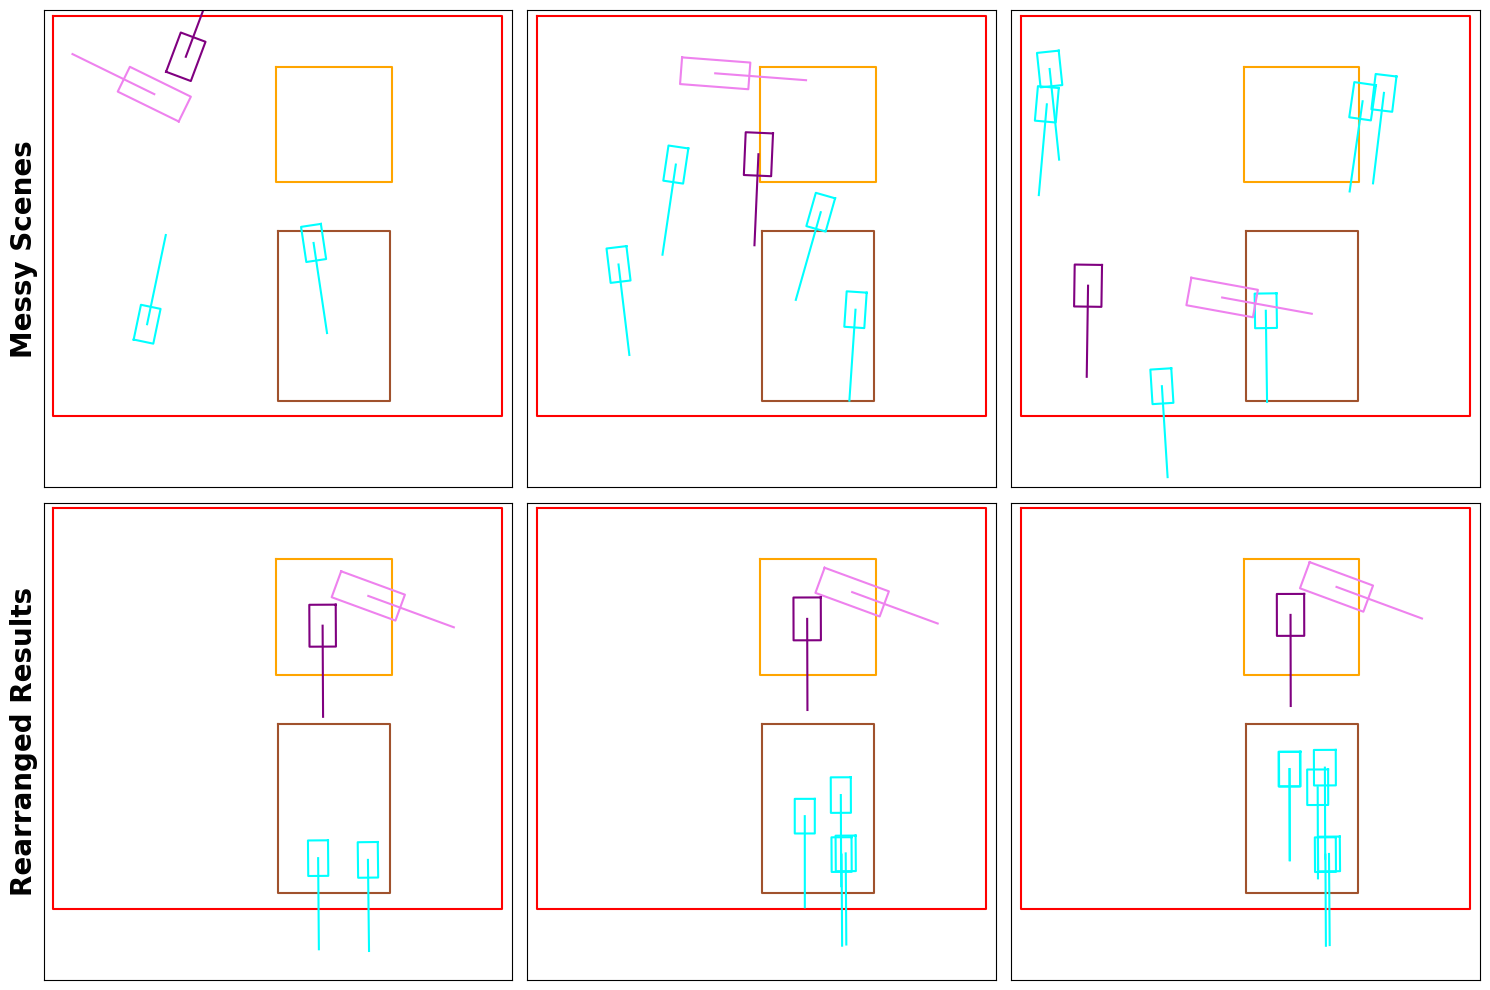

In [3]:
import matplotlib
import matplotlib.pyplot as plt
from scripts.utils import visual_noise, visual_noise_denoise
import random

noise_level_stddev=1.0
angle_noise_level_stddev=np.pi / 3
# OUTPUT_PATH = "qualitive"
# folder = "local"
# os.makedirs(os.path.join(OUTPUT_PATH, folder), exist_ok=True)
fig = plt.figure(figsize=(15, 10))
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight'] = "bold"
matplotlib.rcParams['axes.labelsize'] = 20
category = ["forks", "knives", "spoons", "plates", "bowls", "mugs", "cups", "cans", "boxes", "bottles", "bananas", "berries", "mask", "table"]

cond_scale_guidance = 1.0
adjust_parameters(train = False)
denoiser.eval()
# random_idxes = [1495, 1496, 1497]
# seeds = [36, 42, 93]
random_idxes = [1495, 1496, 1497]
seeds = [36, 42, 67]
for index in range(len(random_idxes)):
    seed = seeds[index]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    t = torch.randint(200, schedule.timesteps, (1,), dtype=torch.long)
    input, mask, cond, word, labels, padding_mask, mask_padding_mask, clean_scenepaths = dataset.gen_kitchen(1, t, schedule, random_idx=np.array([random_idxes[index]]), abs_pos=predict_absolute_pos, abs_ang=predict_absolute_ang, data_partition="train", no_rotate_class=data_config["no_rotate_class"], static_class=[], same_class=[], floorplan_class=data_config["floorplan_class"], within_floorplan=True, no_penetration=True, noise_level_stddev=noise_level_stddev, angle_noise_level_stddev=angle_noise_level_stddev)
    bbox_means, orientations, bbox_sizes = input[:, :, :2], input[:, :, 2:4], input[:, :, 4:6]
    input = torch.tensor(input)
    mask = torch.tensor(mask)
    word = torch.tensor(word)
    labels = torch.tensor(labels)
    padding_mask = torch.tensor(padding_mask)
    mask_padding_mask = torch.tensor(mask_padding_mask)

    args = {}
    args["device"] = input.device
    args['predict_absolute_pos'] = predict_absolute_pos
    args['predict_absolute_ang'] = predict_absolute_ang
    args['train_pos_noise_level_stddev'] = noise_level_stddev
    args['train_ang_noise_level_stddev'] = angle_noise_level_stddev

    # word = torch.LongTensor([[1, 2]])
    # cond_scale_guidance = 2.0
    if index == 0:
        new_mask = mask
        mask_initial = copy.deepcopy(mask)
    else:
        new_mask = mask_initial
    # new_mask = torch.tensor([
    #     [bbox_y-0.1, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 2 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in mask[0]
    #     ]).unsqueeze(0)
    # new_mask = torch.tensor([
    #     [bbox_y-0.2, bbox_x+0.6, a_y, a_x, bbox_h, bbox_w, bbox_type] if bbox_type == 3 else [bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type] for bbox_y, bbox_x, a_y, a_x, bbox_h, bbox_w, bbox_type in new_mask[0]
    #     ]).unsqueeze(0)
    # target_bbox = [(-0.5323, 0.2427, 0.4971, 0.4971, 3), (0.2916, 0.2427, 0.7280, 0.4814, 2), (-0.1389, 0., 1.7221, 1.9295, 1)]
    # t = torch.LongTensor([200])

    idx = 0
    file = clean_scenepaths[idx].replace("pt", "png")
    image = Image.open(file).convert("P")
    w, h = image.size
    nobj, cla_idx = TableDataset.parse_cla(input[idx, :, 6:].numpy())
    nmask, _ = TableDataset.parse_cla(mask[idx, :, 6:].numpy())
    target_bbox = [(bbox_y, bbox_x, bbox_h + 1, bbox_w + 1, bbox_type.int().item()) for bbox_y, bbox_x, _, _, bbox_h, bbox_w, bbox_type in new_mask[idx]]

    # def update(tr):
    #     plt.cla()
    #     visual_noise(clean_scenepaths[idx], traj_to_return[tr], padding_mask[idx], target_bbox=target_bbox)
    #     # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[tr], labels[idx], padding_mask[idx], target_bbox=target_bbox)

    # target_bbox=(-0.3, -0.3, 0.6, 1.2)
    # guidance_scale = 3.0
    with torch.no_grad():
        traj_to_return, _, _, _, perobj_distmoved = denoise_1scene(copy.deepcopy(input), new_mask, cond, un_cond, word, args, "grad_noise", input.device, denoiser, t, schedule, cond_scale_guidance=cond_scale_guidance, guidance=None, guidance_scale=0.0, no_rotate_class=data_config["no_rotate_class"], static_class=[], padding_mask=padding_mask, mask_padding_mask=mask_padding_mask, steer_away=False, denoise_move_less=False)
        emd2gt, ang2gt, iou_25, iou_50, numobj = dist_2_gt(np.expand_dims(traj_to_return[-1], axis=0), labels[[idx]], dataset, use_emd=True)
    print(perobj_distmoved, emd2gt, ang2gt, iou_25 / numobj, iou_50 / numobj)

    ax = fig.add_subplot(2, 3, 1+index)
    visual_noise(clean_scenepaths[idx], traj_to_return[0], padding_mask[idx], target_bbox=target_bbox)
    if index == 0:
        ax.set_ylabel("Messy Scenes")
    ax.set_xticks([])
    ax.set_yticks([])
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[0], labels[idx], padding_mask[idx], target_bbox=target_bbox)
    # loc = {}
    # loc["size"] = torch.tensor([h, w])
    # loc["cla"] = [category[c] for c in cla_idx]
    # loc["obj"] = traj_to_return[0][:nobj, :6]
    # loc["mask"] = new_mask[idx][:nmask]
    # torch.save(loc, os.path.join(OUTPUT_PATH, folder, "messy1.pt"))

    ax = fig.add_subplot(2, 3, 4+index)
    visual_noise(clean_scenepaths[idx], traj_to_return[-1], padding_mask[idx], target_bbox=target_bbox)
    if index == 0:
        ax.set_ylabel("Rearranged Results")
    ax.set_xticks([])
    ax.set_yticks([])
    # visual_noise_denoise(clean_scenepaths[idx], traj_to_return[0], labels[idx], padding_mask[idx], target_bbox=target_bbox)
    # loc = {}
    # loc["size"] = torch.tensor([h, w])
    # loc["cla"] = [category[c] for c in cla_idx]
    # loc["obj"] = traj_to_return[0][:nobj, :6]
    # loc["mask"] = new_mask[idx][:nmask]
    # torch.save(loc, os.path.join(OUTPUT_PATH, folder, "messy2.pt"))

fig.tight_layout()
# fig.savefig('failure_case.pdf', bbox_inches='tight')